# Community Model
We want to combine all 7 bacterial species into one big community model, where bacteria exchange metabolites. This is important to analyse how they interact which each other reagrding e.g. cross-feeding

# Imports and Load Individual Models

In [2]:
# basic
import pandas as pd
import numpy as np
import os
import re
# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
from micom.problems import cooperative_tradeoff
from micom.workflows import tradeoff
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from sqlalchemy.sql.coercions import expect
from upsetplot import UpSet, from_indicators
# from pyvis.network import Network
# Clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Ändert das Anzeigeformat der Gleitkommazahlen
pd.options.display.float_format = '{:.5f}'.format

In [4]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models_filled = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"f")
    models_filled[name] = model

models_filled = {key: models_filled[key] for key in sorted(models_filled.keys())}  # sorts the dictionary alphabetically
AA1f, AA2f, AA3f, AA4f, AA5f, AA6f, AA7f = [models_filled[f"AA{i}f"] for i in range(1, 8)]

In [5]:
# Load well established models for compariso
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = "cplex"
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = "cplex"

In [31]:
def get_amounts(model):
    rxns = len(model.reactions)
    mets = len(model.metabolites)
    print(f"{model.id} has {rxns} reactions and {mets} metabolites")

In [37]:
for model in models.values():
    get_amounts(model)

AA1 has 2261 reactions and 1513 metabolites
AA2 has 2668 reactions and 1788 metabolites
AA3 has 2222 reactions and 1500 metabolites
AA4 has 2795 reactions and 1757 metabolites
AA5 has 2107 reactions and 1446 metabolites
AA6 has 2578 reactions and 1685 metabolites
AA7 has 2521 reactions and 1654 metabolites


In [33]:
for model in models_filled.values():
    get_amounts(model)

AA1 has 2261 reactions and 1513 metabolites
AA2 has 2668 reactions and 1788 metabolites
AA3 has 2222 reactions and 1500 metabolites
AA4 has 2795 reactions and 1757 metabolites
AA5 has 2112 reactions and 1447 metabolites
AA6 has 2578 reactions and 1685 metabolites
AA7 has 2521 reactions and 1654 metabolites


In [8]:
set([rxn.id for rxn in AA5f.reactions]) - set([rxn.id for rxn in AA5.reactions])
# make sure that reactions were added to the gap filled model but no artefacts remain (like sink reactions from testing gap filling)

{'ACGS', 'G1PACT', 'PGAMT'}

# Functions

In [6]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

# change medium
def change_medium(model, medium_dict):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    if model.id == "C7":
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium_dict.items()}
        #print(medium_dict)

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)


# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict, frac=1):

    with model:
        change_medium(model, medium_dict)

        try:
            if model.id != "C7":
                solution = pfba(model)
                growth = solution.fluxes["Growth"]
            else:
                solution = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
                growth = solution[solution.index.str.contains("Growth")].transpose()
                growth = growth[~ growth.index.str.contains("medium")]
                growth.index.name = "model"
                growth = growth["Growth"]
            return growth
        except Infeasible:
            #print(f"Model {model.id} is infeasible with the given medium.")
            return None
        except OptimizationError as e:
            #print(f"OptimizationError for model {model.id}: {e}")
            return None


# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()

    return df


# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        # med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        #####
        if carbon_only:
            carbon_sources = carbon if isinstance(carbon, list) else [carbon]
            med_dict = {
                met: medium_uptake_bound if met in carbon_sources else 1000
                for met in new_medium}
        else:
            med_dict = {met: medium_uptake_bound for met in new_medium}
        #####

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            if isinstance(growth_val, pd.Series) and growth_val is not None:
                #print(carbon, growth_val)
                #growth_val = sum(pd.DataFrame(growth_val)["fluxes"])/7
                growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()/7
            results[carbon_key][model.id] = growth_val
        #print("-----")

    return visualise_heatmap_medium(results)

In [7]:
def check_early_biomass_component(model, medium_dict, check_rxn_id):
    rxn_id = "objective_check"
    sad_mets = []

    check_mets = model.reactions.get_by_id(check_rxn_id).metabolites
    #check_mets = model.reactions.check_rxn_id.metabolites
    for met, flux in check_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="objective reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])

            model.objective = rxn_id

            with model:
                change_medium(model, medium_dict)
                try:
                    pfba_flux = pfba(model)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    print(sad_mets)

In [8]:
def pca(df):
    # Standardise the data
    scaler = StandardScaler()
    growth_df_filled = df.fillna(0)
    scaled_growth = scaler.fit_transform(growth_df_filled)

    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_growth)

    # Create df for PCA result
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df.index)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

    # Annotate each point with the community name
    for name, row in pca_df.iterrows():
        if name != "C7_Community":
            plt.text(row["PC1"] + 0.07, row["PC2"]-0.04, name, fontsize=9)
        else:
            plt.text(row["PC1"] + -0.1, row["PC2"]+0.1, name, fontsize=9)

    # Add variance explained info
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
    plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")

    plt.title("PCA")
    #plt.xlim(-3, 3)
    #plt.ylim(-3, 2)
    plt.grid(True)
    #plt.savefig("../Figures/pca.svg", format="svg", bbox_inches="tight")
    plt.show()

# Create Community Model
we want to combine our 7 models into one; they'll share one compartment where they can exchange metabolites.

In [20]:
for model in models.values():
    model.reactions.ATPM.lower_bound = 1
    model.reactions.ATPM.upper_bound = 1

## MICOM

with A7; if you run everything without changes we'll get infeasible flux solution; only if I change all lower bounds of all EXchange reactions to -1000 then we get a feasible solution (MICOM changed the lower bounds for all EX reactions that go from a bacterium into the medium to -100)

in comparison i tried the whole community model creation without AA7 and there it works directly without changing anything

In [9]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
taxonomy

,id,genus,species,reactions,metabolites,file,abundance
0,AA1,Stenotrophomonas,Stenotrophomonas maltophilia,2261,1513,/home/lisa/Dokumente/Programmierung/Models/10_...,16
1,AA2,Brucella,Brucella pituitosa,2669,1789,/home/lisa/Dokumente/Programmierung/Models/10_...,5
2,AA3,Curtobacterium,Curtobacterium pusillum,2223,1501,/home/lisa/Dokumente/Programmierung/Models/10_...,8
3,AA4,Enterobacter,Enterobacter ludwigii,2795,1758,/home/lisa/Dokumente/Programmierung/Models/10_...,65
4,AA5,Chryseobacterium,Chryseobacterium indologenes,2107,1446,/home/lisa/Dokumente/Programmierung/Models/10_...,1
5,AA6,Herbaspirillum,Herbaspirillum robiniae,2578,1685,/home/lisa/Dokumente/Programmierung/Models/10_...,2
6,AA7,Pseudomonas,Pseudomonas putida,2522,1655,/home/lisa/Dokumente/Programmierung/Models/10_...,3


I talked with Nadine in my meeting on the 06 June and we decided that at the beginning we're not going to use abundances

In [10]:
# without abundance
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [11]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

### Community with gap filled models

In [12]:
taxonomy_gap_filled = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom_filled = Community(taxonomy_gap_filled.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [13]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom_filled.reactions.query("^EX_"):
    rxn.lower_bound = -1000

## Evaluate Syncom

In [9]:
# TODO: use different abundancies and check if biomass is different and especially check if bounds of EX reactions changed
# i think they dont change the bounds but the stoichiometry of reactions

In [21]:
syncom_EX = syncom.reactions.query("^EX_")
print(f"My syncom has in total {len(syncom_EX)} EX reactions.")

My syncom has in total 2571 EX reactions.


In [ ]:
total_EX = 0
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    total_EX += len(EX)
    print(f"Model {model.id} has {len(EX)} EX reactions.")
print(f"That means there are in total {total_EX} EX reactions in my 7 models.")

syncom_nonM_EX = [rxn for rxn in syncom.reactions.query("^EX_") if not rxn.id.endswith("m")]
print(f"There are {len(syncom_nonM_EX)} EX reactions from my models into shared medium in the syncom.")

In [ ]:
all_EX = set()
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    all_EX.update(EX)
print(f"There are {len(all_EX)} unique EX reactions in my 7 models.", )

EX_syncom_m = [rxn for rxn in syncom.reactions.query("^EX_") if rxn.id.endswith("m")]
print(f"There are {len(EX_syncom_m)} EX reactions from/into _m in my syncom.", )

In [ ]:
trimmed_all_EX = {s[:-2] for s in all_EX}  # assuming all_EX is a set of strings
trimmed_EX_syncom_m = {rxn.id[:-2] for rxn in EX_syncom_m}  # handle Reaction objects

diff = trimmed_all_EX - trimmed_EX_syncom_m
diff

In [ ]:
diff = trimmed_EX_syncom_m - trimmed_all_EX
diff

In [ ]:
syncom.reactions.query("EX_acon_C")

In [ ]:
for rxn in syncom.reactions.query("^EX_"):
    print(rxn.id[len(rxn.id)-3:], rxn.lower_bound)

### without A7

In [ ]:
# only using model 1-6 works
smoll_com = Community(pd.read_csv("../Datasets/smoll_community_model.csv", sep=";"), name="uwu", id="smoll", solver="cplex")

In [ ]:
smoll_com.optimize()

In [ ]:
smoll_com.cooperative_tradeoff()

### Micom Test Data

In [ ]:
from micom.data import test_taxonomy

taxonomy_test = test_taxonomy()
taxonomy_test

In [ ]:
from micom import Community

com = Community(taxonomy_test)

In [ ]:
from micom.data import test_db
from micom.data import test_data

data = test_data()
data

In [ ]:
taxonomy = pd.read_csv("../Datasets/community_model_build.csv", sep=";")

In [ ]:
from micom.workflows import build
manifest = build(taxonomy=taxonomy, out_folder="../", cutoff=0.0001, threads=2, model_db=None, solver="cplex")

In [ ]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_ARE_Jin.csv", sep=";")

In [ ]:
medium_mre_m9 = pd.concat([m9, mre_jin], ignore_index=True)

In [ ]:
from micom.workflows import grow
res = grow(manifest, model_folder="../", medium=medium_mre_m9, tradeoff=0.5, threads=2)

In [ ]:
print(com.objective.expression)
com.optimize()

In [ ]:
sol = com.cooperative_tradeoff(fraction=1.0)
sol

In [ ]:
com

## PyCoMo
wir bleiben bei MICOM, da das mehr etabliert ist

In [ ]:
from pathlib import Path
import sys
import cobra
import os

In [ ]:
path_root = "/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/pycomo-0.2.8.dist-info"
sys.path.append(path_root)
import pycomo
pycomo.configure_logger(level="INFO")

In [ ]:
test_model_dir = "../Models/10_duplicate_removal"
# needed to change solver to cplex
named_models = pycomo.load_named_models_from_dir(test_model_dir)

In [ ]:
for model in named_models.values():
    print(model.objective)

In [ ]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

In [ ]:
community_name = "lisas_endless_pain"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

In [ ]:
com_model_obj.model

In [ ]:
# at the moment there is a fixed grwoth but with variable abundance
com_model_obj.summary()

In [ ]:
# we can change the simulation that we have set abundance and variable grwoth (like it should be)
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

# Medium

In [14]:
def e_to_m(medium):
    if isinstance(medium, dict):
        # Convert reaction IDs ending in '_e' to '_m'
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium.items()}
        return medium_dict

    elif isinstance(medium, pd.DataFrame):
        # Convert DataFrame to a dict with converted reaction IDs
        medium_dict = {rxn.removesuffix('_e') + '_m' if rxn.endswith('_e') else rxn: bound for rxn, bound in zip(medium["reaction"], medium["bound"])}
        return medium_dict

    else:
        return "Medium is wrong data type"

In [29]:
def change_medium_bounds(medium_df, carbon_bound, non_carbon_bound=1000):
    if not isinstance(medium_df, pd.DataFrame):
        return "please df :c"

    medium_df = medium_df.copy()

    medium_df["bound"] = np.where(
    medium_df["reaction"].isin(m9_rxn),
        non_carbon_bound,   # value if reaction is in m9_rxn
        carbon_bound)       # value if not

    return medium_df

## M9

In [16]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")

In [17]:
m9_rxn = list(m9["reaction"])

## Maize Root Exudate

In [18]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_MRE_Naveed.csv", sep=";")

In [19]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_MRE_Krumbach.csv", sep=";")
# this is the more core medium

In [ ]:
# this is the very extensive list of metabolites from LC-MS aka table s1
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)
print(len(set(og_medium[0])))
set(og_medium[0])

In [15]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_MRE_Jin.csv", sep=";")

## Combined MARE & M9 with bounds

In [20]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

In [21]:
combined_med_wo_bz = medium_combined_krumbach[medium_combined_krumbach['reaction'] != 'EX_bz_e']

## Ashley Beck

In [22]:
medium_beck = pd.read_csv("../Datasets/Medium/medium_Beck.csv", sep=";")

## Ecoplate

In [23]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Medium comparison

In [19]:
set_jin = set(mre_jin["reaction"])
set_naveed = set(mre_naveed["reaction"])
set_krumbach = set(mre_krumbach["reaction"])

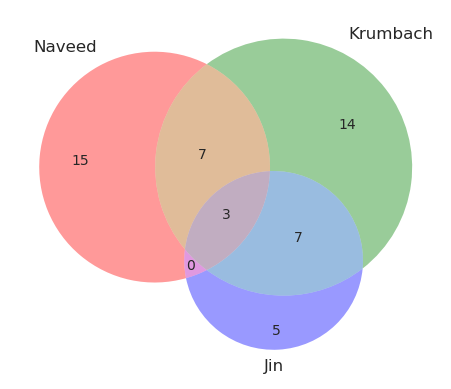

In [19]:
from matplotlib_venn import venn3
venn3((set_naveed, set_krumbach, set_jin), set_labels=('Naveed', 'Krumbach', 'Jin'))
plt.show()

In [20]:
# Create a union of all reactions
all_reactions = set_naveed | set_krumbach | set_jin

# Build a DataFrame showing presence (1) or absence (0) in each set
venn_df = pd.DataFrame({
    'reaction': list(all_reactions),
    'in_naveed': [1 if rxn in set_naveed else 0 for rxn in all_reactions],
    'in_krumbach': [1 if rxn in set_krumbach else 0 for rxn in all_reactions],
    'in_jin': [1 if rxn in set_jin else 0 for rxn in all_reactions]
})

# Simulations

In [24]:
all_models = {**models, 'Community': syncom}

In [25]:
all_models_filled = {**models_filled, 'Community': syncom_filled}

The limited version is when all the bacteria in the community actually share one medium, so they would only have 1/7 of the og medium.

## Growth on Maize ARE & M9

When comparing the Naveed and krumbach medium, there are especially differences in the community. Because with krumbach we see growth for AA1 which isn't the case for naveed. AA3 doesnt show growth at the moment in the individual models because of the low bounds for the carbon soirces in the medium.

In [ ]:
# there is definitely a difference between pfba and the cooperative tradeoff function from MICOM
# with pfba i dont have growth for aa1 and aa5 in the community, that is why when i first used the krumbach medium
# i kinda dismissed it because there wasnt really a change in comparison to naveed
# but now with the micom function there actually is
with syncom:
    chill_medium = change_medium_bounds(medium_combined_krumbach, 1000)
    change_medium(syncom, chill_medium)
    com_fluxes = pfba(syncom_filled).fluxes # funnily i get NO error with the syncom that is not filled but maybe that was luck

# gets you an error because of pFBA

In [28]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_beck)
    print(model.id, ": ", growth_val)

AA1 :  5.0030164718646475
AA2 :  14.15858413403532
AA3 :  1.6721018815020643
AA4 :  10.92502857049456
AA5 :  10.859283612963113
AA6 :  10.973764769857768
AA7 :  14.882999372232263
C7 :  model
AA1   14.64887
AA2   18.18318
AA3    6.05547
AA4   14.79370
AA5   19.00178
AA6   13.74655
AA7   15.84036
Name: Growth, dtype: float64


In [25]:
for model in all_models.values():
    chill_medium = change_medium_bounds(medium_beck, 200, non_carbon_bound=1000)
    growth_val = test_medium(model, chill_medium)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  23.363103231066148
AA3 :  8.408898203581192
AA4 :  39.94555916162176
AA5 :  0.0
AA6 :  28.51455181697144
AA7 :  27.19425311230267
C7 :  model
AA1   31.29966
AA2   38.39613
AA3   24.99789
AA4   43.23286
AA5    0.04155
AA6   43.14488
AA7   42.81015
Name: Growth, dtype: float64


In [35]:
for model in all_models_filled.values():
    print(test_medium(model, medium_combined_krumbach))

12.024833169938836
0.0
1.9584272055034424
16.735081796546577
12.546880595533839
15.041286709543826
17.700553077472527
model
AA1   17.88144
AA2   18.82748
AA3   14.36891
AA4   18.99878
AA5   16.59485
AA6   18.68613
AA7   12.86152
Name: Growth, dtype: float64


In [36]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  12.67283923788905
AA2 :  0.0
AA3 :  1.1878371099638019
AA4 :  16.83807369120486
AA5 :  13.221299050785134
AA6 :  14.004887056963659
AA7 :  16.064020079876975
C7 :  model
AA1   12.49156
AA2   14.59692
AA3    0.00019
AA4   33.90512
AA5   19.88793
AA6   19.99917
AA7   19.96862
Name: Growth, dtype: float64


In [99]:
for model in all_models.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.838073691204926
AA5 :  0.0
AA6 :  14.004887056963659
AA7 :  11.229605821567402
C7 :  model
AA1    0.00000
AA2   26.64465
AA3    1.35513
AA4   42.47803
AA5    0.00012
AA6   24.86469
AA7   12.38754
Name: Growth, dtype: float64


In [63]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.838073691204894
AA5 :  0.0
AA6 :  14.00488705696367
AA7 :  11.229605821567311
C7 :  model
AA1    0.00019
AA2   21.76565
AA3    0.40104
AA4   37.97523
AA5   21.17109
AA6   21.20286
AA7   12.90419
Name: Growth, dtype: float64


In [ ]:
chill_bounds = change_medium_bounds(medium_combined_naveed, 501)
for model in all_models_filled.values():
    growth_val = test_medium(model, chill_bounds)
    print(model.id, ": ", growth_val)

In [56]:
growth_ind_krumbach = []
growth_ind_naveed = []
growth_com_krumbach = []
growth_com_naveed = []
for model in all_models_filled.values():
    ### Krumbach
    growth_val = test_medium(model, medium_combined_krumbach, frac=1)
    if model.id == "C7":
        growth_com_krumbach = growth_val
    else:
        growth_ind_krumbach.append(growth_val)
    print(model.id, ": ", growth_val, "K")

    ### Naveed
    growth_val = test_medium(model, medium_combined_naveed, frac=1)
    if model.id == "C7":
        growth_com_naveed = growth_val
    else:
        growth_ind_naveed.append(growth_val)
    print(model.id, ": ", growth_val, "N")

AA1 :  12.024833169938855 K
AA1 :  12.672839237889017 N
AA2 :  0.0 K
AA2 :  0.0 N
AA3 :  1.9584272055034484 K
AA3 :  1.1878371099638085 N
AA4 :  16.735081796546645 K
AA4 :  16.838073691204908 N
AA5 :  12.546880595533949 K
AA5 :  13.221299050785197 N
AA6 :  15.041286709543893 K
AA6 :  14.004887056963648 N
AA7 :  17.70055307747252 K
AA7 :  16.06402007987706 N
C7 :  model
AA1   17.88144
AA2   18.82748
AA3   14.36891
AA4   18.99878
AA5   16.59485
AA6   18.68613
AA7   12.86152
Name: Growth, dtype: float64 K
C7 :  model
AA1   12.49156
AA2   14.59692
AA3    0.00019
AA4   33.90512
AA5   19.88793
AA6   19.99917
AA7   19.96862
Name: Growth, dtype: float64 N


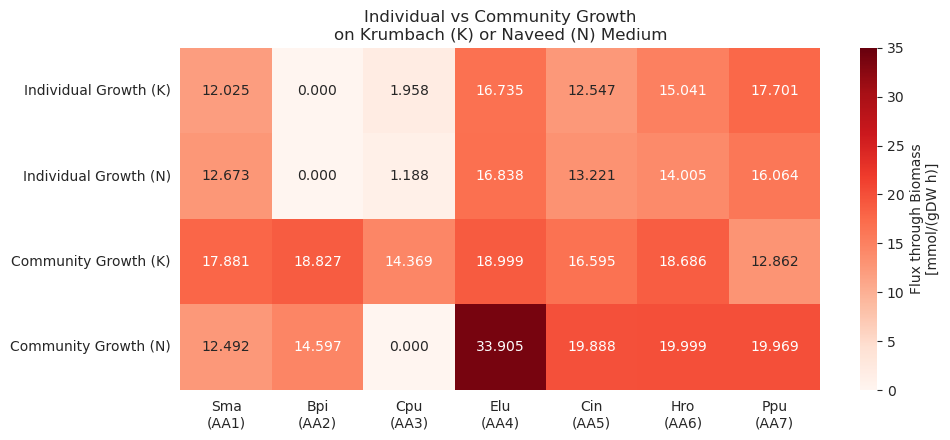

In [64]:
data = np.array([growth_ind_krumbach, growth_ind_naveed, list(growth_com_krumbach), list(growth_com_naveed)])
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

df = pd.DataFrame(data,
                  index=["Individual Growth (K)", "Individual Growth (N)", "Community Growth (K)", "Community Growth (N)"],
                  columns=bac_names)

plt.figure(figsize=(10, 4.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=35)
plt.title("Individual vs Community Growth\non Krumbach (K) or Naveed (N) Medium")
plt.tight_layout()

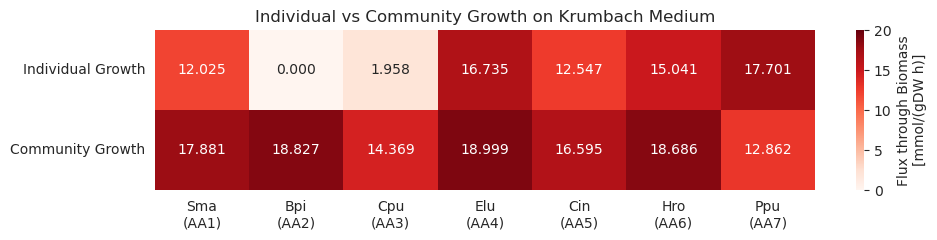

In [61]:
# Combine into 2D array for heatmap
growth_ind = [0 if x is None else x for x in growth_ind_krumbach]
data = np.array([growth_ind, list(growth_com_krumbach)])

#bac_names = ["AA1", "AA2", "AA3", "AA4", "AA5", "AA6", "AA7"]
#bac_names = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

# Create a DataFrame for better labeling
df = pd.DataFrame(data,
                  index=["Individual Growth", "Community Growth"],
                  columns=bac_names)

#tree_order = ["Cin", "Ppu", "Sma", "Elu", "Bpi", "Hro", "Cpu"]
#df = df[tree_order]  # Reorder columns

# Plot
plt.figure(figsize=(10, 2.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=20)
plt.title("Individual vs Community Growth on Krumbach Medium")
plt.tight_layout()
#plt.show()
#plt.savefig("../Figures/Biomass_Ind_Com_KrumbachMed.svg")

In [31]:
with syncom:
    change_medium(syncom, combined_med_wo_bz)
    syncom_fluxes = (syncom.cooperative_tradeoff(fluxes=True, pfba=True, fraction=1).fluxes.transpose())

In [49]:
# frowin removed all benzoate reactions involving bz_p and bz_p itself; only left transport c <--> e
# maybe i should try that because AA6 is really shuffling its benzoate through the compartments lol :D

In [66]:
from itertools import product

suffices = ["__AA1", "__AA2", "__AA3", "__AA4", "__AA5", "__AA6", "__AA7"]
bz_knockouts = ["BZtex", "BZt2_pp", "BZt1pp"]
knocks_reaction_ids = [bz + suf for bz, suf in product(bz_knockouts, suffices)]

with syncom:
    # Knockout: BZtex, BZt2_pp, BZt1pp
    for rxn_id in knocks_reaction_ids:
        if rxn_id in syncom.reactions:
            syncom.reactions.get_by_id(rxn_id).knock_out()

    change_medium(syncom, combined_med_wo_bz)
    syncom_fluxes_knocked = (syncom.cooperative_tradeoff(fluxes=True, pfba=True, fraction=1).fluxes.transpose())


In [67]:
with syncom:
    change_medium(syncom, combined_med_wo_bz)
    syncom_fluxes = (syncom.cooperative_tradeoff(fluxes=True, pfba=True, fraction=1).fluxes.transpose())

In [64]:
with syncom:
    change_medium(syncom, medium_combined_krumbach)
    syncom_fluxes_bz = (syncom.cooperative_tradeoff(fluxes=True, pfba=True, fraction=1).fluxes.transpose())

In [68]:
with syncom:
    change_medium(syncom, medium_combined_naveed)
    syncom_fluxes_naveed = (syncom.cooperative_tradeoff(fluxes=True, pfba=True, fraction=1).fluxes.transpose())

it is also important to note that for the community I really should use the cooperative tradeoff function from MICOM; normal pfba() gets me infeasible solution quite often

AA2 is able to grow within the community model although it was previously not able to grow on its own (nice!) AA2 needed thiamine to grow. \
AA1 and AA5 are still not growing. \
For AA1 it could be worth a try to change orn__D and orn

In [55]:
for model in all_models.values():
    growth_val = test_medium(model, combined_med_wo_bz)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.735081796546574
AA5 :  0.0
AA6 :  0.0
AA7 :  0.0
C7 :  model
AA1   15.32679
AA2   17.84343
AA3   15.54849
AA4   19.12454
AA5    0.01511
AA6   19.14474
AA7   15.76383
Name: Growth, dtype: float64


lets check AA2 within the community

In [ ]:
with syncom:
    change_medium(syncom, medium_mre_m9)
    c7 = pfba(syncom).fluxes

In [ ]:
c7[(c7.index.str.contains('Growth'))
   ]

In [ ]:
c7[(c7.index.str.startswith('EX_')) &
   (c7.index.str.endswith('_AA2')) &
   (c7 < 0)]

In [ ]:
# AA7 secretes thm into medium
c7[(c7.index.str.contains('thm_e')) &
    (c7 > 0)]

In [ ]:
with AA7:
    change_medium(AA7, medium_combined_krumbach)
    aa7 = pfba(AA7).fluxes

In [ ]:
aa7[(aa7.index.str.contains('thm_e'))]
# AA7 only secretes thm in the community, on its own, it doesnt do that

lets check why the community doesnt need bz in the medium

In [ ]:
with syncom:
    change_medium(syncom, combined_med_wo_bz)
    c7 = pfba(syncom).fluxes

In [ ]:
c7[(c7.index.str.contains('Growth')) ]

In [ ]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 > 0)]

In [ ]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 < 0)]

just because we see no growth in AA1 and AA5 doesnt mean they're dead, i think they're just vibing without growth because we still see fluxes

In [ ]:
c7[(c7.index.str.contains('AA5')) &
    (c7 != 0)]

In [ ]:
c7[(c7.index.str.contains('AA1')) &
    (c7 != 0)]

## Ecoplate Substrate Utilisation

In [33]:
metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "4-Hydroxy benzoic acid", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]

[08/06/25 10:27:47] WARNING  solver encountered an error infeasible                                 ]8;id=74407;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=818124;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[08/06/25 10:27:48] WARNING  solver encountered an error infeasible                                 ]8;id=259869;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=962262;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[08/06/25 10:28:15] WARNING  solver encountered an error infeasible                                 ]8;id=219795;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=862868;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[08/06/25 10:28:16] WARNING  solver encountered an error infeasible                                 ]8;id=162469;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=842211;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

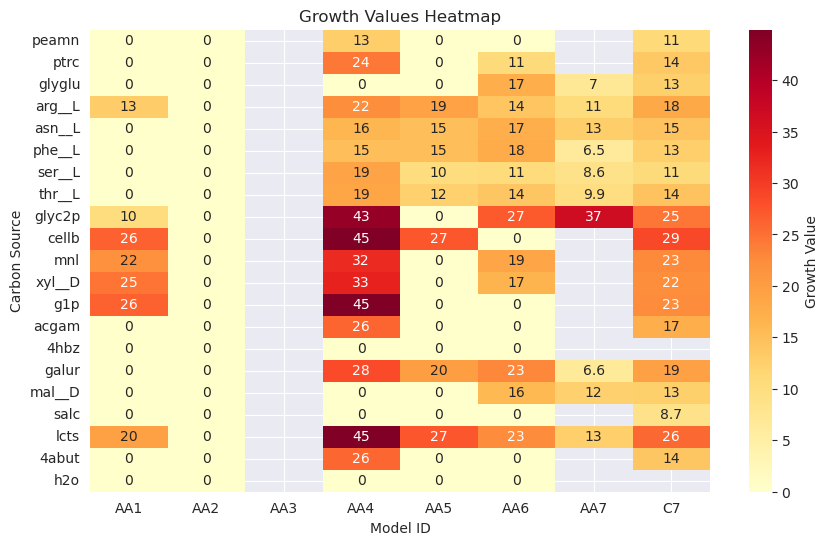

In [27]:
# AA7 is very sensitive to changes the bounds, it needs >500 to grow
ecoplate_df = create_medium(ecoplate_rxns, m9_rxn, all_models_filled, 1000)

In [39]:
ecoplate_df.index = metab_axis
ecoplate_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
ecoplate_df = ecoplate_df.fillna(0)

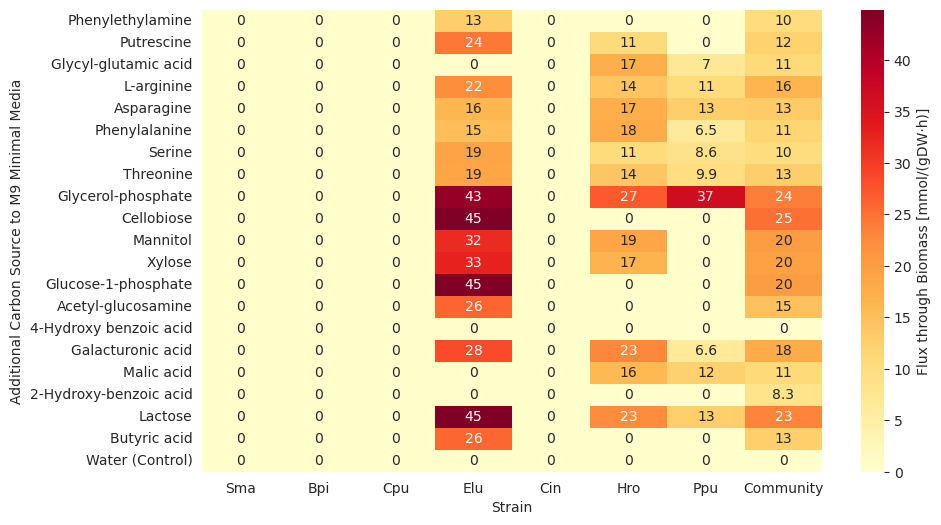

In [43]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
plt.savefig("../Figures/ecoplate.svg", format="svg", bbox_inches="tight")
plt.show()


In [ ]:
# all reactions in the M9 have a bound of 1000, only bounds of carbon reactions are modified
# AA7 can grow with carbon sources <500, i.e. especially O2 is limiting (i saw that in other simulations, that o2 ans fructose were the ones with highest flux values)
create_medium(ecoplate_rxns, m9_rxn, all_models, 45, carbon_only=True)

In [ ]:
# without benzoate in medium
create_medium(ecoplate_rxns, m9_rxn[:-1], all_models, 1000)

## Growth on Different Carbon Sources

In [44]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

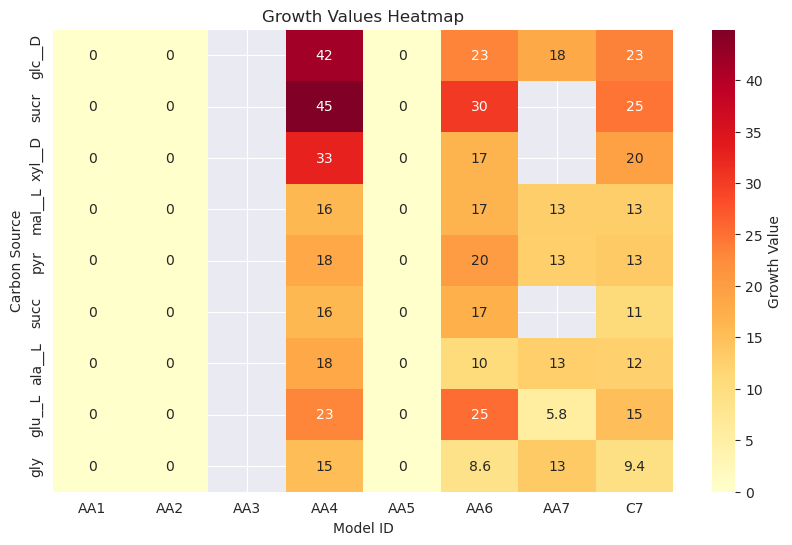

In [45]:
carbon_df = create_medium(carbon_sources, m9_rxn, all_models, 1000)

In [49]:
carbon_df.index = ["Glucose", "Sucrose", "Xylose", "Malate", "Pyruvate", "Succinate", "Alanine", "Glutamate", "Glycine"]
carbon_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
carbon_df = carbon_df.fillna(0)

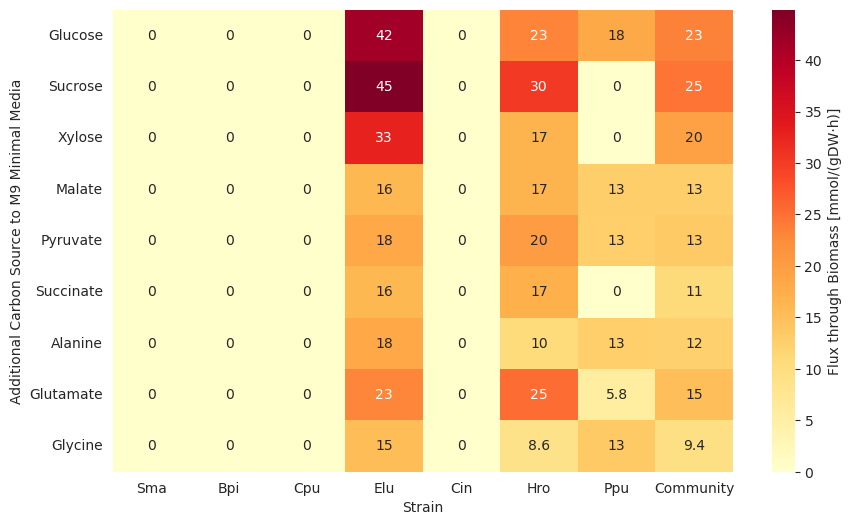

In [51]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(carbon_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
plt.savefig("../Figures/growth_diff_carbon_sources.svg", format="svg", bbox_inches="tight")
plt.show()

## Aufnahme und Abgabe

In [64]:
def compare_rxn_lists(com_index, single_index, model_id):
    # Convert to sets
    set1 = list(com_index)
    set2 = set(single_index)

    # Cut off the last 5 characters from each ID in list1
    set1 = set([rxn[:-5] for rxn in set1])

    # Reactions in both lists
    shared = set1 & set2  # or set1.intersection(set2)

    # unique reactions
    unique_to_list1 = set1 - set2
    unique_to_list2 = set2 - set1

    #print("Shared reactions:", sorted(shared))
    #print(f"Unique to Community-{model_id}:", sorted(unique_to_list1))
    #print(f"Unique to {model_id}:", sorted(unique_to_list2))

    return shared, unique_to_list1, unique_to_list2

In [75]:
def convert_cooptradeoff_into_fluxes(model, medium=None, frac=1):

    if hasattr(model, "modification") and model.modification is not None:
        model.modification = None


    with model:
        if medium is not None:
            change_medium(model, medium)
        pfba_fluxes = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
        df_long = pfba_fluxes.melt(ignore_index=False, var_name='model', value_name='flux')
        df_long = df_long.reset_index()

        df_long['reaction_id'] = np.where(
            df_long['model'] != 'medium',
            df_long['reaction'] + "__" + df_long['model'],
            df_long['reaction'])

        rxns_in_syncom = set(r.id for r in syncom.reactions)
        df_long = df_long[df_long['reaction_id'].isin(rxns_in_syncom)]
        pfba_fluxes = df_long.set_index('reaction_id')['flux']
        return pfba_fluxes

In [66]:
def get_pfba_fluxes(model, medium, frac=1):
    with model:
        change_medium(model, medium)
        try:
            if model.id != "C7":
                pfba_fluxes = pfba(model).fluxes
            else:
                pfba_fluxes = convert_cooptradeoff_into_fluxes(model, frac=frac)
            #pfba_fluxes = pfba(model).fluxes
            return pfba_fluxes
        except Infeasible:
            return None

In [67]:
def get_fluxes_for_heatmap(model, medium, type, c7_all_ex="no", dict_with_rxn="no"):
    fluxes = get_pfba_fluxes(model, medium)

    if fluxes is None:
        print(model.id)
        return {}

    if type == "uptake":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes < 0)]
    elif type == "secret":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    # this decides if we just include medium EX or all EX between the bacteria
    if model.id == "C7" and c7_all_ex == "no":
        filtered_fluxes = filtered_fluxes[(filtered_fluxes.index.str.endswith('_m'))]

    # i need that option for later; i need the EX reaction names and not the metabolite names
    if dict_with_rxn == "yes":
        return filtered_fluxes

    flux_dict = {}
    for rxn_id, flux in filtered_fluxes.items():
        rxn = model.reactions.get_by_id(rxn_id)
        # Exchange reactions should have exactly one metabolite on one side
        met_id = list(rxn.metabolites.keys())[0].name  # us .id or use .name
        flux_dict[met_id] = flux

    #print(flux_dict.keys())
    return flux_dict

In [68]:
def uptake_secret_heatmap(all_models, type, initial_medium=None, c7_all_ex="no", vmin=1e-5):
    data = {}

    for model_name, model_obj in all_models.items():
        if initial_medium is None:
            medium = minimal_medium(model_obj, 2)
            medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
            flux_dict = get_fluxes_for_heatmap(model_obj, medium, type, c7_all_ex)
        else:
            flux_dict = get_fluxes_for_heatmap(model_obj, initial_medium, type, c7_all_ex)
        data[model_name] = flux_dict  # keys: model names, values: dict of metabolite: flux

    df = pd.DataFrame(data).fillna(0)
    df = df.abs() # absolute values, so even negative fluxes have right colour scale that |-1000| is bigger than 0
    df = df.replace(0, np.nan)

    #vmin = 1e-5  # threshold: if all flux values for a metabolite are below, they dont show up in the plot to not screw the color scale too much
    df_filtered = df[df.max(axis=1) >= vmin]

    # Depending on Uptake or Secretion, choose different color scale
    color_map = {"uptake": "Blues", "secret": "Reds"}
    base_cmap_name = color_map[type]

    # Build custom colormap that starts with white
    base = sns.color_palette(base_cmap_name, 256).as_hex()
    custom_colors = ["#ffffff"] + base[1:]  # replace first entry with white
    custom_cmap = LinearSegmentedColormap.from_list(f"{base_cmap_name}_custom", custom_colors)

    # Plot heatmap
    plt.figure(figsize=(12, min(len(df_filtered) * 0.4, 32)))
    plt.grid(False)

    ax = sns.heatmap(
        df_filtered,
        cmap=custom_cmap,
        norm=LogNorm(vmin=vmin, vmax=df_filtered.max().max()),
        cbar_kws={"label": "Flux (log scale)"},
        mask=df_filtered == 0,  # hide zero-flux cells
        linewidths=0.01,
        linecolor="whitesmoke"
    )

    # Clean up axes and background grid artifacts
    ax.set_facecolor("white")  # fill background of masked cells with white
    sns.despine(left=True, bottom=True)  # remove spines
    ax.tick_params(length=0)  # remove tick marks

    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    #plt.show()

    """ without logarithmic scale
    # Plot heatmap
    plt.figure(figsize=(12, len(df) * 0.4))
    sns.heatmap(
        df,
        cmap=custom_cmap,
        vmin=0,  # ensures white is only used at exactly 0
        vmax=df.max().max(),  # max flux defines the top of the gradient
        linewidths=0.01,
        linecolor="whitesmoke",
        cbar_kws={"label": "Flux"}
    )
    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    plt.show()
    """

    return df_filtered

AA3


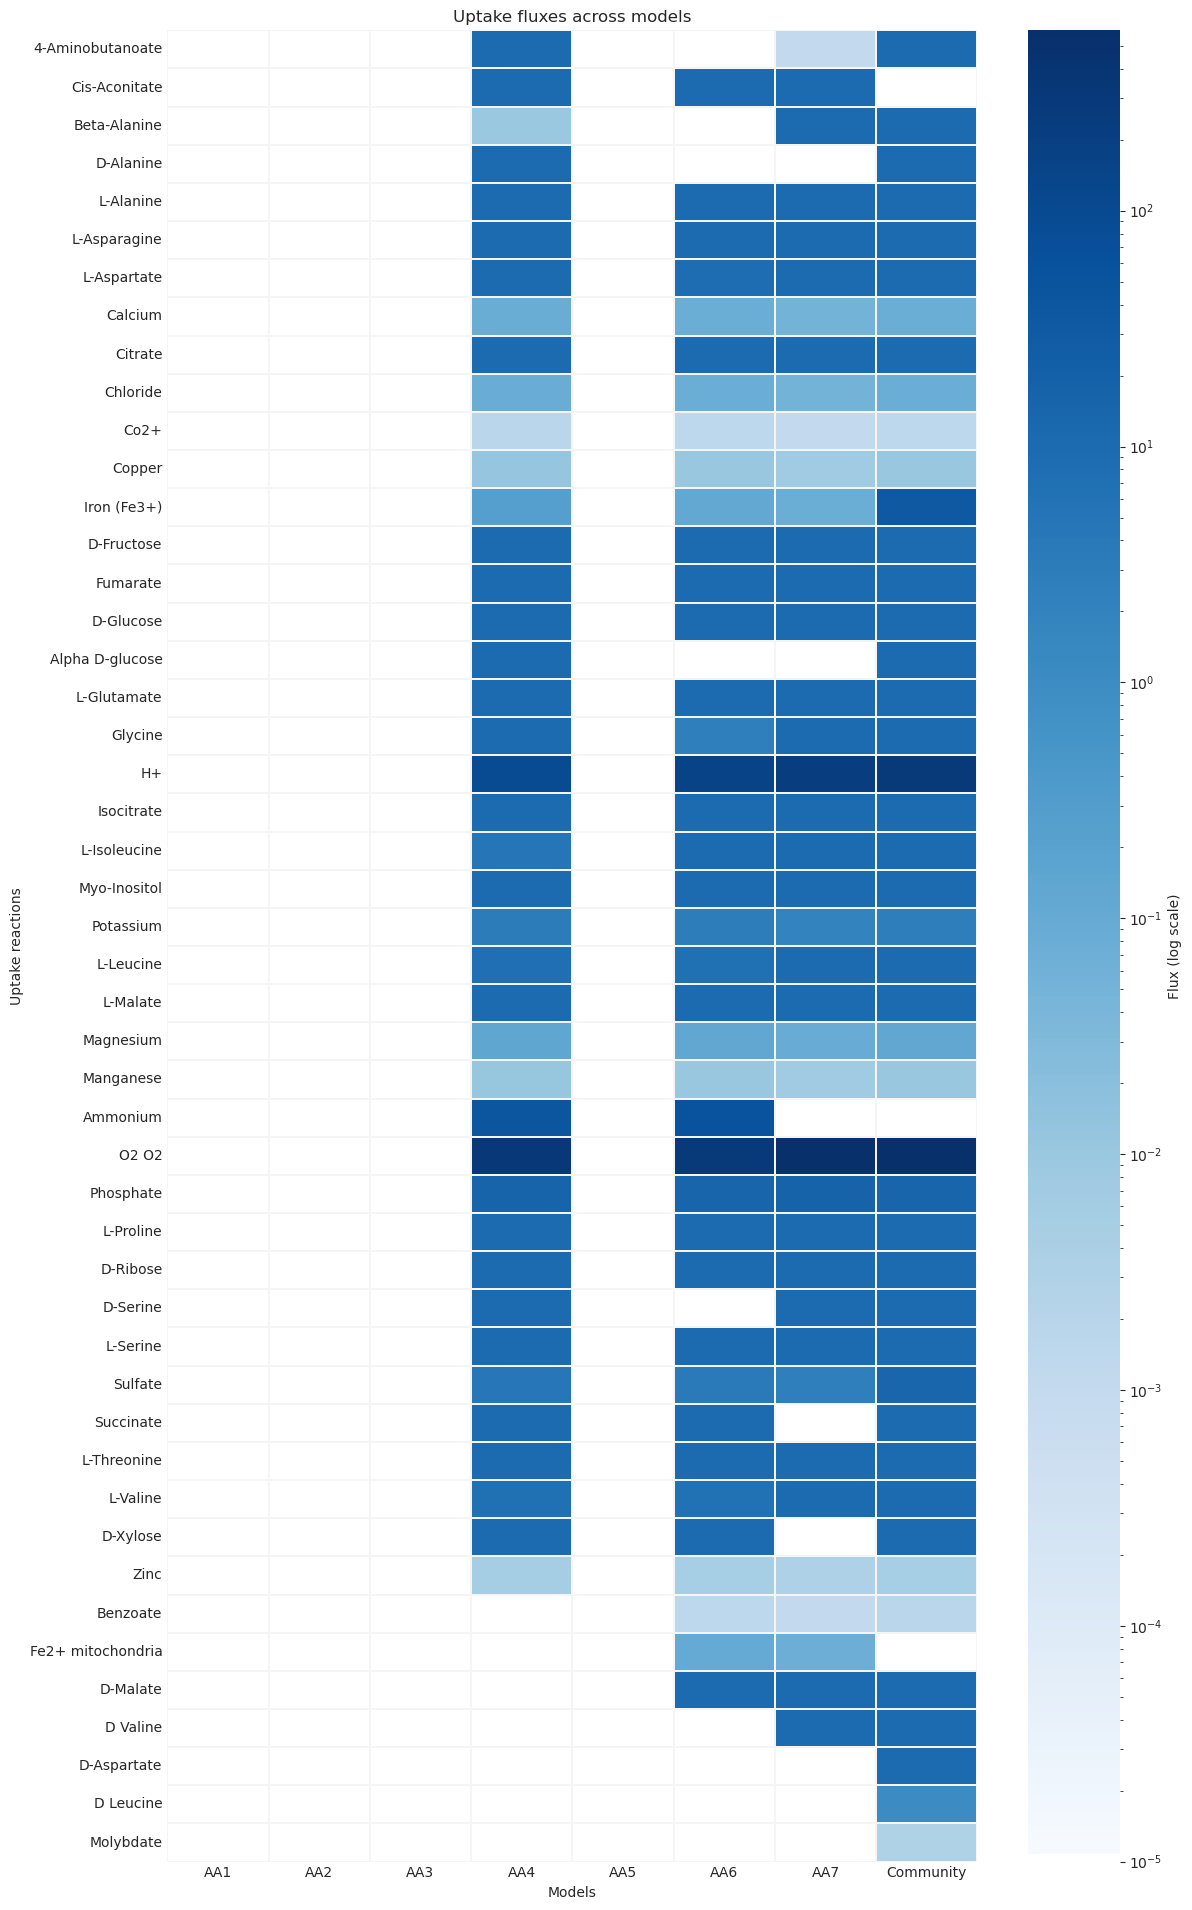

In [30]:
# the code for the community works in a way it only looks at EX reactions into/from the medium and outside and NO EX into/from a model into the medium
uptake_df = uptake_secret_heatmap(all_models, "uptake", medium_combined_krumbach)

AA3


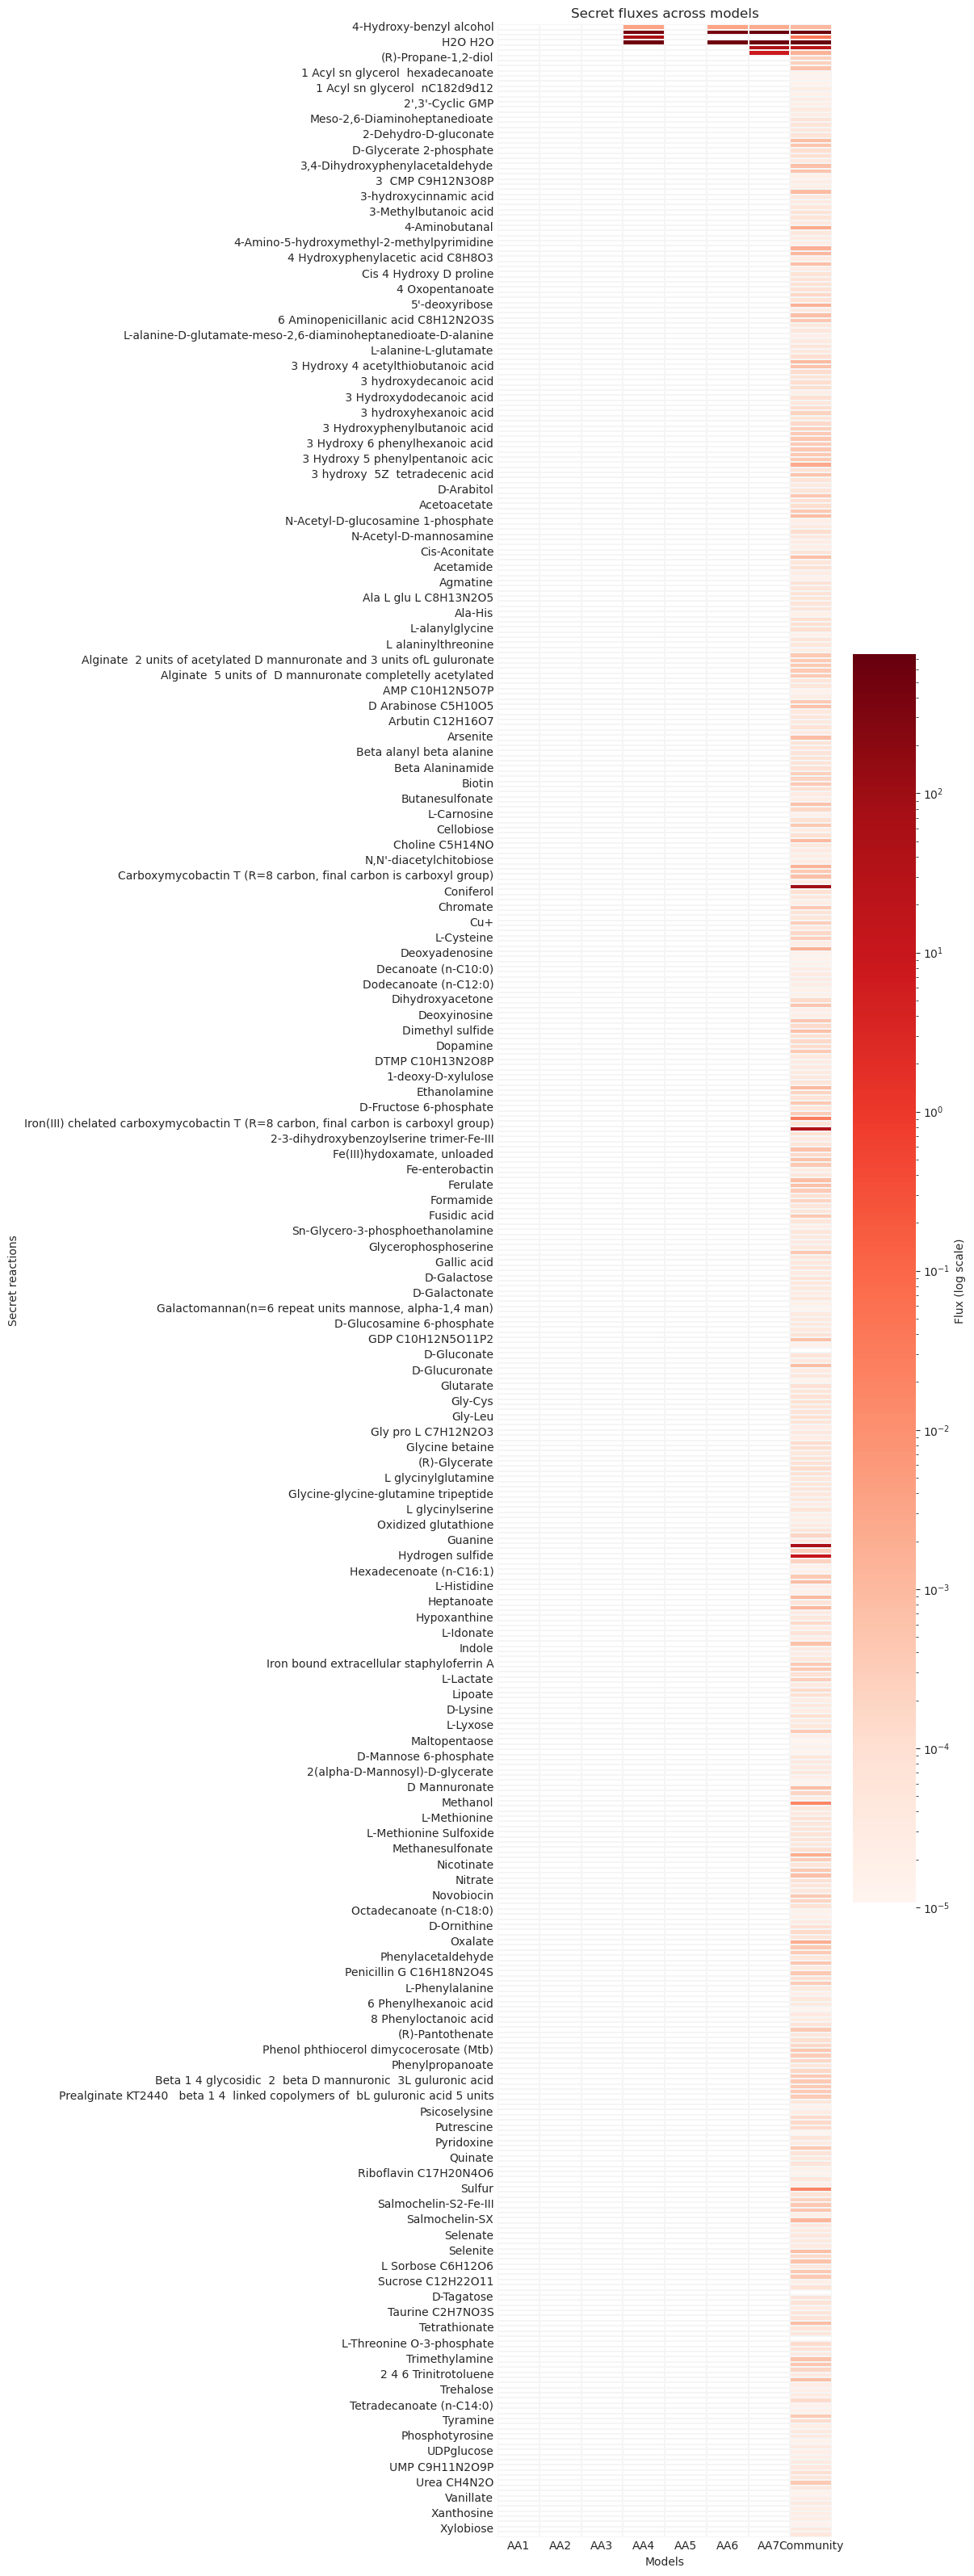

In [31]:
secretion_df = uptake_secret_heatmap(all_models, "secret", medium_combined_krumbach)

it may be interessting to see the metabolic niches of all my bacteria. but because some of them are not able to grow on their own, i would disregard the medium right now and maybe use the minimal medium for each of the bacteria determined by cobrapy.

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


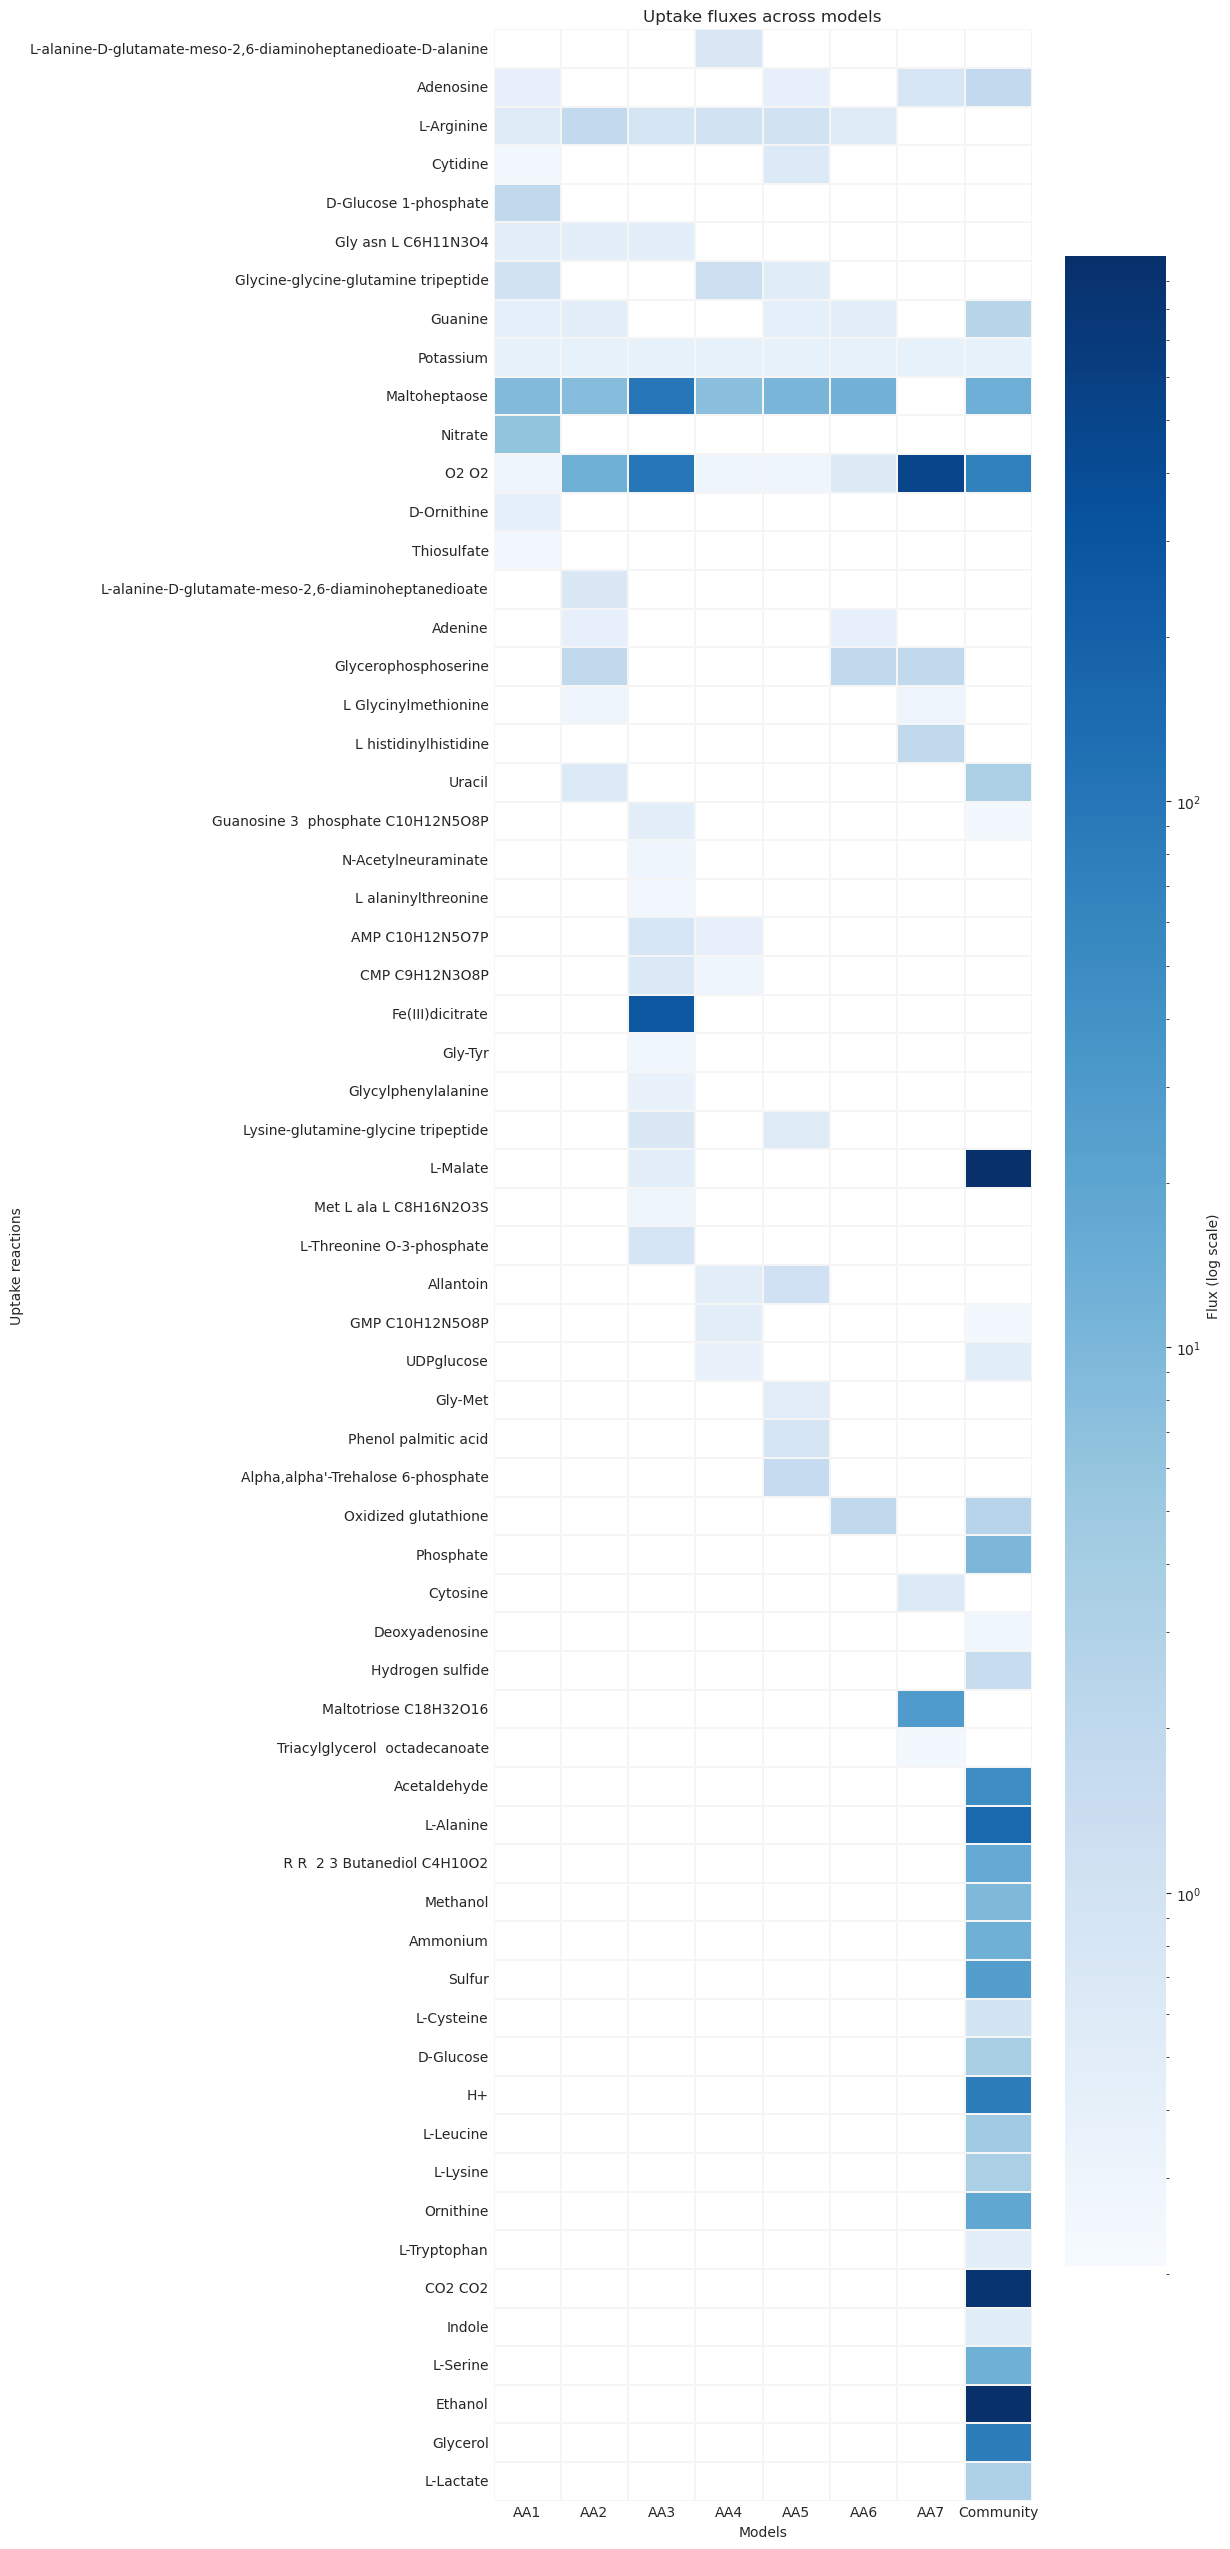

In [86]:
df_uptakes_all = uptake_secret_heatmap(all_models, "uptake", c7_all_ex="yes", vmin=0.2)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,AA1,AA2,AA3,AA4,AA5,AA6,AA7,Community
Acetaldehyde,2.524448e+01,23.044967,1000.000000,NaN,19.784134,59.338348,NaN,2.457611e+01
CO2 CO2,1.083301e+02,107.642587,1000.000000,6.651713e+01,141.723182,116.558767,504.911797,6.779112e-06
Ethanol,7.364891e+01,74.149090,NaN,NaN,90.978397,97.864461,NaN,2.191992e-04
Hydrogen sulfide,2.841893e-13,NaN,NaN,1.404987e-13,NaN,3.469201,NaN,4.641898e+00
L-Lactate,7.959121e+00,NaN,NaN,NaN,NaN,3.631525,0.436124,2.424768e-06
Methanol,NaN,0.196260,136.678312,NaN,NaN,NaN,NaN,4.035288e-06
3 Hydroxyhexadecanoic acid,NaN,NaN,9.004697,NaN,NaN,NaN,NaN,2.031359e-05
Carbon monoxide,NaN,NaN,78.892690,NaN,NaN,49.455587,NaN,5.164757e-06
Iron (Fe3+),NaN,NaN,269.486027,NaN,NaN,NaN,NaN,7.680382e-07
H2O H2O,NaN,NaN,280.332952,NaN,NaN,NaN,452.548740,1.153551e+02


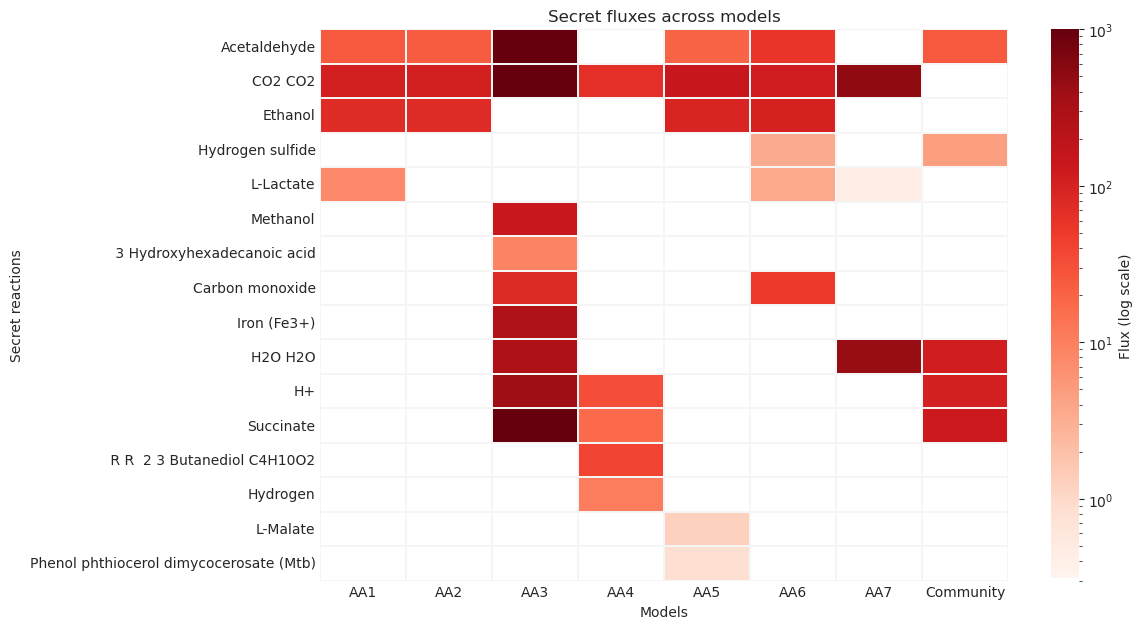

In [85]:
uptake_secret_heatmap(all_models, "secret", c7_all_ex="yes", vmin=0.3)

I think the community lacks a bit of uptake because the above plots only check for uptake/secretion into the medium from the outside. all metabolites that are secreted and uptaken by the members are disregarded. however in the paper it is very likely that the would measure that as well because the medium compartment doesnt exist in RL

Get the Uptakes and Secretion Fluxes more in detail; Comparison between individual model and their behaviour in the community

In [30]:
def get_uptake_secrets(model, medium, type):
    syncom_fluxes = get_pfba_fluxes(syncom, medium)
    single_flux = get_pfba_fluxes(model, medium)

    if type == "uptake":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes < 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux < 0)]
    elif type == "secret":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes > 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    shared, unique_to_com, unique_to_single = compare_rxn_lists(com_uptakes.index, single_uptakes.index, model.id)
    return shared, unique_to_com, unique_to_single


In [ ]:
uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared = [], [], [], [], [], []

for model in models.values():
    up_shared, up_unique_to_com, up_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "uptake")
    uptake_single.append(up_unique_to_single)
    uptake_com.append(up_unique_to_com)
    uptake_shared.append(up_shared)

    sec_shared, sec_unique_to_com, sec_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "secret")
    secret_single.append(sec_unique_to_single)
    secret_com.append(sec_unique_to_com)
    secret_shared.append(sec_shared)

# if Infeasible, change the bounds within the Community to 1000, see MICOM creation

In [ ]:
labels = [f"AA{i}" for i in range(1, 8)]  # ['AA1', 'AA2', ..., 'AA7']
df_uptakes_secrets = pd.DataFrame({
    'model': labels,
    'uptake_single': uptake_single,
    'uptake_com': uptake_com,
    'uptake_shared': uptake_shared,
    'secret_single': secret_single,
    'secret_com': secret_com,
    'secret_shared': secret_shared
})

In [ ]:
df_uptakes_secrets

In [ ]:
from itertools import chain
# Flatten two levels: from list of sets to a single iterable of elements
unique_list = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared]))))
uptake_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared]))))
secret_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    secret_single, secret_com, secret_shared]))))
unique_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, secret_single, secret_com]))))

### Uptakes within Community

check within community who produces what for whom

In [69]:
model_ids = [f"AA{i}f" for i in range(1,8)]
epsilon = 1e-6

In [70]:
with syncom_filled:
    change_medium(syncom_filled, medium_combined_krumbach)
    com_fluxes = convert_cooptradeoff_into_fluxes(syncom)
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction_id"})

    com_fluxes["flux"] = com_fluxes["flux"].apply(lambda x: 0 if abs(x) < epsilon else x)

Why does AA3 start to grow in Community when on its own, the bounds of carbon sources are too low?

In [64]:
aa3_fluxes = pfba(AA3).fluxes

In [65]:
aa3_fluxes = aa3_fluxes.reset_index()
aa3_fluxes.columns = ['reaction_id', 'flux']

In [ ]:
threshold = 1e-4

In [67]:
aa3_uptakes_ind = aa3_fluxes[
    aa3_fluxes['reaction_id'].str.contains(r'^EX_', regex=True) &
    (aa3_fluxes['flux'].abs() > threshold)
]

In [63]:
aa3_uptakes = com_fluxes[
    com_fluxes['reaction_id'].str.contains(r'^EX_.*AA3', regex=True) &
    (com_fluxes['flux'].abs() > threshold)
]

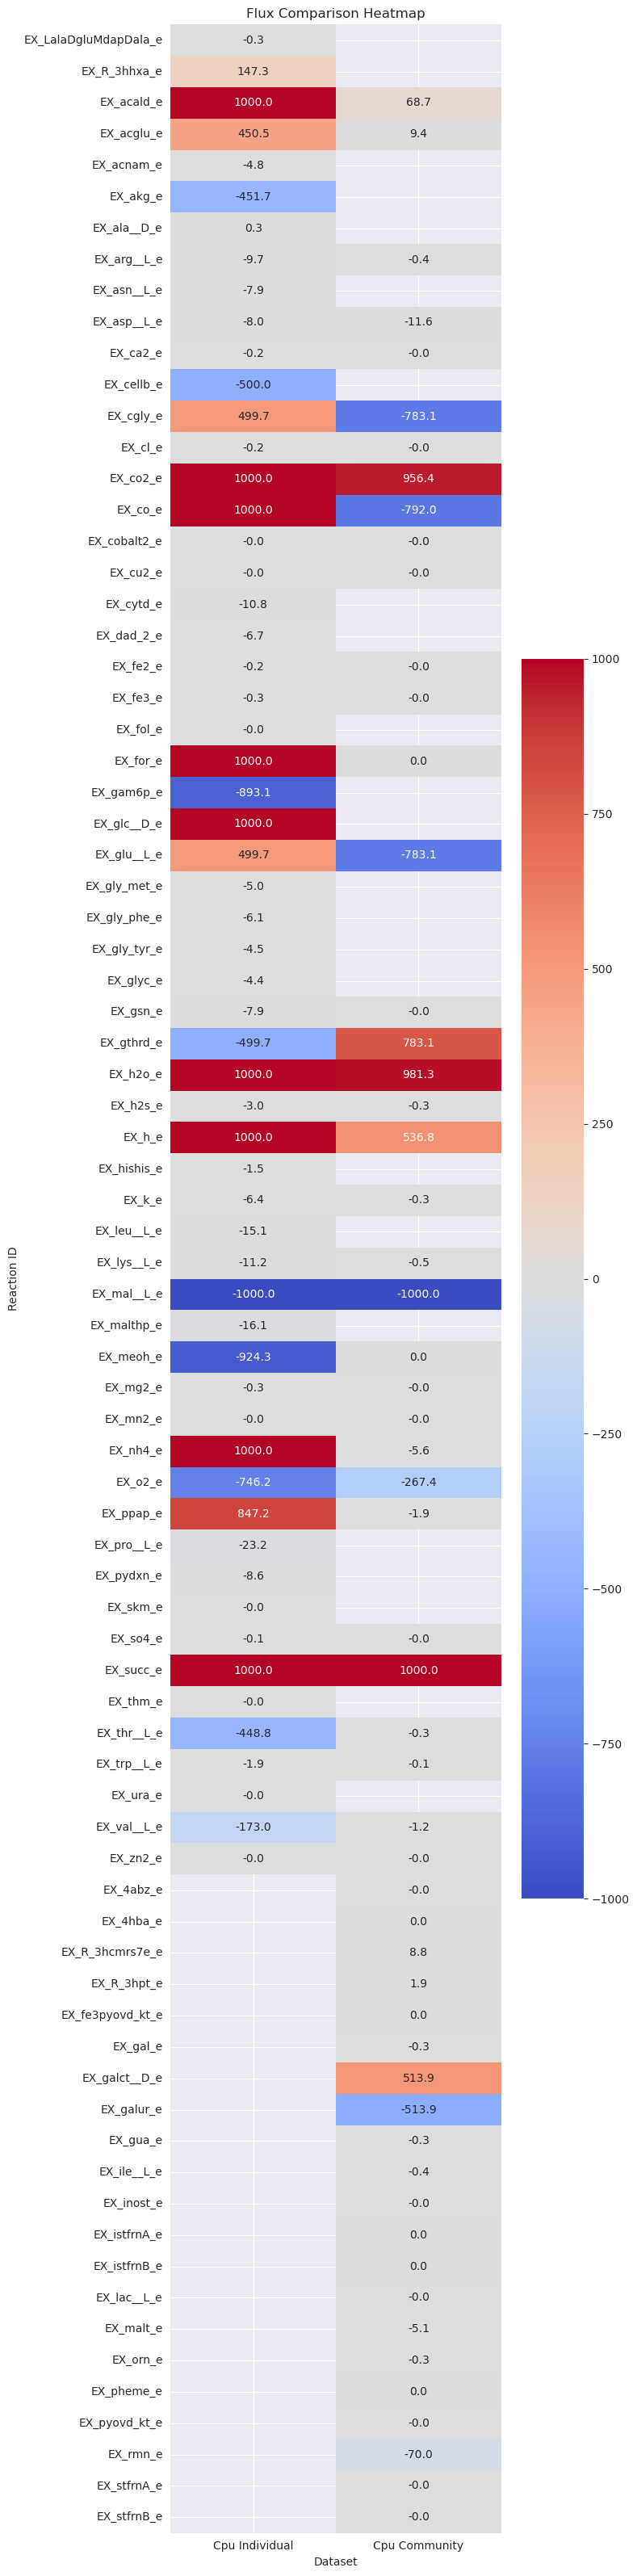

In [74]:
# Clean df2 reaction IDs
aa3_uptakes.loc[:, 'reaction_id'] = aa3_uptakes['reaction_id'].str.replace(r'__AA3$', '', regex=True)

# Merge on cleaned reaction_id
heatmap_df = pd.concat([
    aa3_uptakes_ind.set_index('reaction_id')['flux'],
    aa3_uptakes.set_index('reaction_id')['flux']
], axis=1)

# Rename columns for clarity
heatmap_df.columns = ['Cpu Individual', 'Cpu Community']

# Optional: drop NaNs if you only want shared reactions
# heatmap_df = heatmap_df.dropna()

# Plot heatmap
plt.figure(figsize=(8, len(heatmap_df) * 0.4))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", center=0,fmt=".1f")
plt.title("Flux Comparison Heatmap")
plt.xlabel("Dataset")
plt.ylabel("Reaction ID")
plt.tight_layout()
plt.show()


could be because of EX_glu__L_e: it uptakes it in community while glutamate is produced on its own \
--> glutamate not in medium but nice carbon source \
--> blue uptakes and red secretion \
it is very interesting, there are the some metabolites with the same flux: so glu, gthrd and cgly belong together? GGTAe2: gthrd_e + h2o_e <=> cgly_e + glu__L_e

In [77]:
with syncom_filled:
    com_fluxes = convert_cooptradeoff_into_fluxes(syncom_filled, medium_combined_krumbach)
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction_id"})
    com_fluxes["flux"] = com_fluxes["flux"].apply(lambda x: 0 if abs(x) < epsilon else x)

In [72]:
with syncom_filled:
    change_medium(syncom_filled, medium_combined_krumbach)
    com_fluxes = pfba(syncom_filled).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction_id"})
    com_fluxes["flux"] = com_fluxes["flux"].apply(lambda x: 0 if abs(x) < epsilon else x)

OptimizationError: None (numeric).

In [78]:
# Convert index to strings explicitly
com_fluxes.index = com_fluxes.index.astype(str)

In [86]:
uptakes = []
secretes = []
model_ids = [f"AA{i}" for i in range(1,8)]
for model in model_ids:
    uptake_flux = com_fluxes[
        (com_fluxes['reaction_id'].str.startswith('EX_')) &
        (com_fluxes['reaction_id'].str.endswith(model)) &
        (com_fluxes['flux'] < 0)
    ]
    uptakes.append(uptake_flux)

    secret_flux = com_fluxes[
        (com_fluxes['reaction_id'].str.startswith('EX_')) &
        (com_fluxes['reaction_id'].str.endswith(model)) &
        (com_fluxes['flux'] > 0)
    ]
    secretes.append(secret_flux)


In [88]:
# Step 1: Collect all EX reaction IDs from individual models (without AA suffix)
all_ex_rxns = set()
model_ids = [f"AA{i}" for i in range(1,8)]
for model_id in model_ids:
    model_id = model_id+"f"
    model = models_filled[model_id]
    ex_rxns = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_") and rxn.id.endswith("_e")]
    all_ex_rxns.update(ex_rxns)

all_ex_rxns = sorted(all_ex_rxns)

# Step 2: Create full IDs like EX_glc__D_e__AA1 to match community flux index
uptake_data = {model_id: [] for model_id in model_ids}
secretion_data = {model_id: [] for model_id in model_ids}

flux_dict = dict(zip(com_fluxes['reaction_id'], com_fluxes['flux']))

for base_rxn_id in all_ex_rxns:
    for model_id in model_ids:
        com_rxn_id = f"{base_rxn_id}__{model_id}"
        flux = flux_dict.get(com_rxn_id, None)

        epsilon = 0.001  # or whatever threshold you consider "effectively zero"
        # Uptake: flux significantly < 0
        if flux is not None and flux < -epsilon:
            uptake_data[model_id].append(flux)
        else:
            uptake_data[model_id].append(None)

        # Secretion: flux significantly > 0
        if flux is not None and flux > epsilon:
            secretion_data[model_id].append(flux)
        else:
            secretion_data[model_id].append(None)


# Step 3: Build DataFrames
uptake_df = pd.DataFrame(uptake_data, index=all_ex_rxns)
uptake_df.index.name = "reaction"

secretion_df = pd.DataFrame(secretion_data, index=all_ex_rxns)
secretion_df.index.name = "reaction"


In [82]:
def sort_reactions_by_model_presence(df):
    """Sort reactions: first those used by AA1, then AA2, etc."""
    seen = set()
    sorted_reactions = []

    for model_id in df.columns:
        present_reactions = df[df[model_id].notna()].index.tolist()
        new_reactions = [rxn for rxn in present_reactions if rxn not in seen]
        sorted_reactions.extend(new_reactions)
        seen.update(new_reactions)

    return df.loc[sorted_reactions]

def make_zero_white_cmap(base_cmap='Blues', n=256):
    cmap = plt.get_cmap(base_cmap, n)
    colors = cmap(np.linspace(0, 1, n))
    mid = n // 2
    colors[mid] = np.array([1, 1, 1, 1])  # white for zero flux
    return mcolors.ListedColormap(colors)

def clean_ex_reaction_ids(index):
    """Remove EX_ prefix and _e suffix from exchange reaction IDs."""
    return index.str.replace(r"^EX_", "", regex=True).str.replace(r"_e$", "", regex=True)

In [83]:
def heatmap_fluxes_withinCommunity(df_fluxes, type):
    df = pd.DataFrame(df_fluxes).fillna(0)
    df = df.abs() # absolute values, so even negative fluxes have right colour scale that |-1000| is bigger than 0
    df = df.replace(0, np.nan)

    vmin = 1e-5  # threshold: if all flux values for a metabolite are below, they dont show up in the plot to not screw the color scale too much
    df_filtered = df[df.max(axis=1) >= vmin]

    color_map = {"uptake": "Blues", "secret": "Reds"}
    base_cmap_name = color_map[type]

    # Build custom colormap that starts with white
    base = sns.color_palette(base_cmap_name, 256).as_hex()
    custom_colors = ["#ffffff"] + base[1:]  # replace first entry with white
    custom_cmap = LinearSegmentedColormap.from_list(f"{base_cmap_name}_custom", custom_colors)


    # Plot heatmap
    plt.figure(figsize=(12, len(df_filtered) * 0.4))
    plt.grid(False)

    ax = sns.heatmap(
        df_filtered,
        cmap=custom_cmap,
        norm=LogNorm(vmin=vmin, vmax=1000),
        cbar_kws={"label": "Flux (log scale)"},
        mask=df_filtered == 0,  # hide zero-flux cells
        linewidths=0.01,
        linecolor="whitesmoke"
    )

    # Clean up axes and background grid artifacts
    ax.set_facecolor("white")  # fill background of masked cells with white
    sns.despine(left=True, bottom=True)  # remove spines
    ax.tick_params(length=0)  # remove tick marks

    plt.title(f"{type} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"reactions")
    #plt.tight_layout()
    plt.show()

In [89]:
# Prepare data
filtered_uptake = uptake_df.dropna(how='all')
sorted_uptake = sort_reactions_by_model_presence(filtered_uptake)
plot_uptake = sorted_uptake.fillna(0)

# Clean reaction names for y-axis
plot_uptake.index = clean_ex_reaction_ids(plot_uptake.index.to_series())

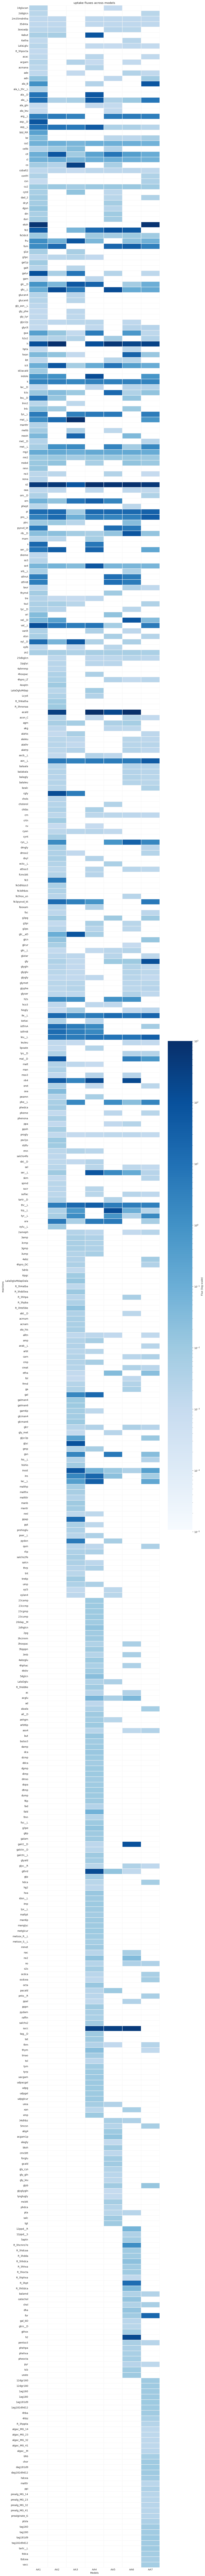

In [90]:
heatmap_fluxes_withinCommunity(plot_uptake, "uptake")

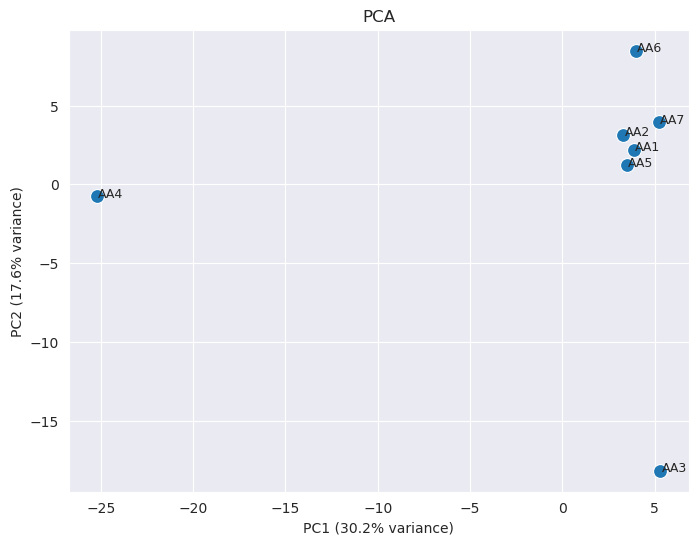

In [43]:
pca(plot_uptake.T)

In [44]:
# Prepare data for secretion
filtered_secretion = secretion_df.dropna(how='all')
sorted_secretion = sort_reactions_by_model_presence(filtered_secretion)
plot_secretion = sorted_secretion.fillna(0)

# Clean reaction names for y-axis
plot_secretion.index = clean_ex_reaction_ids(plot_secretion.index.to_series())

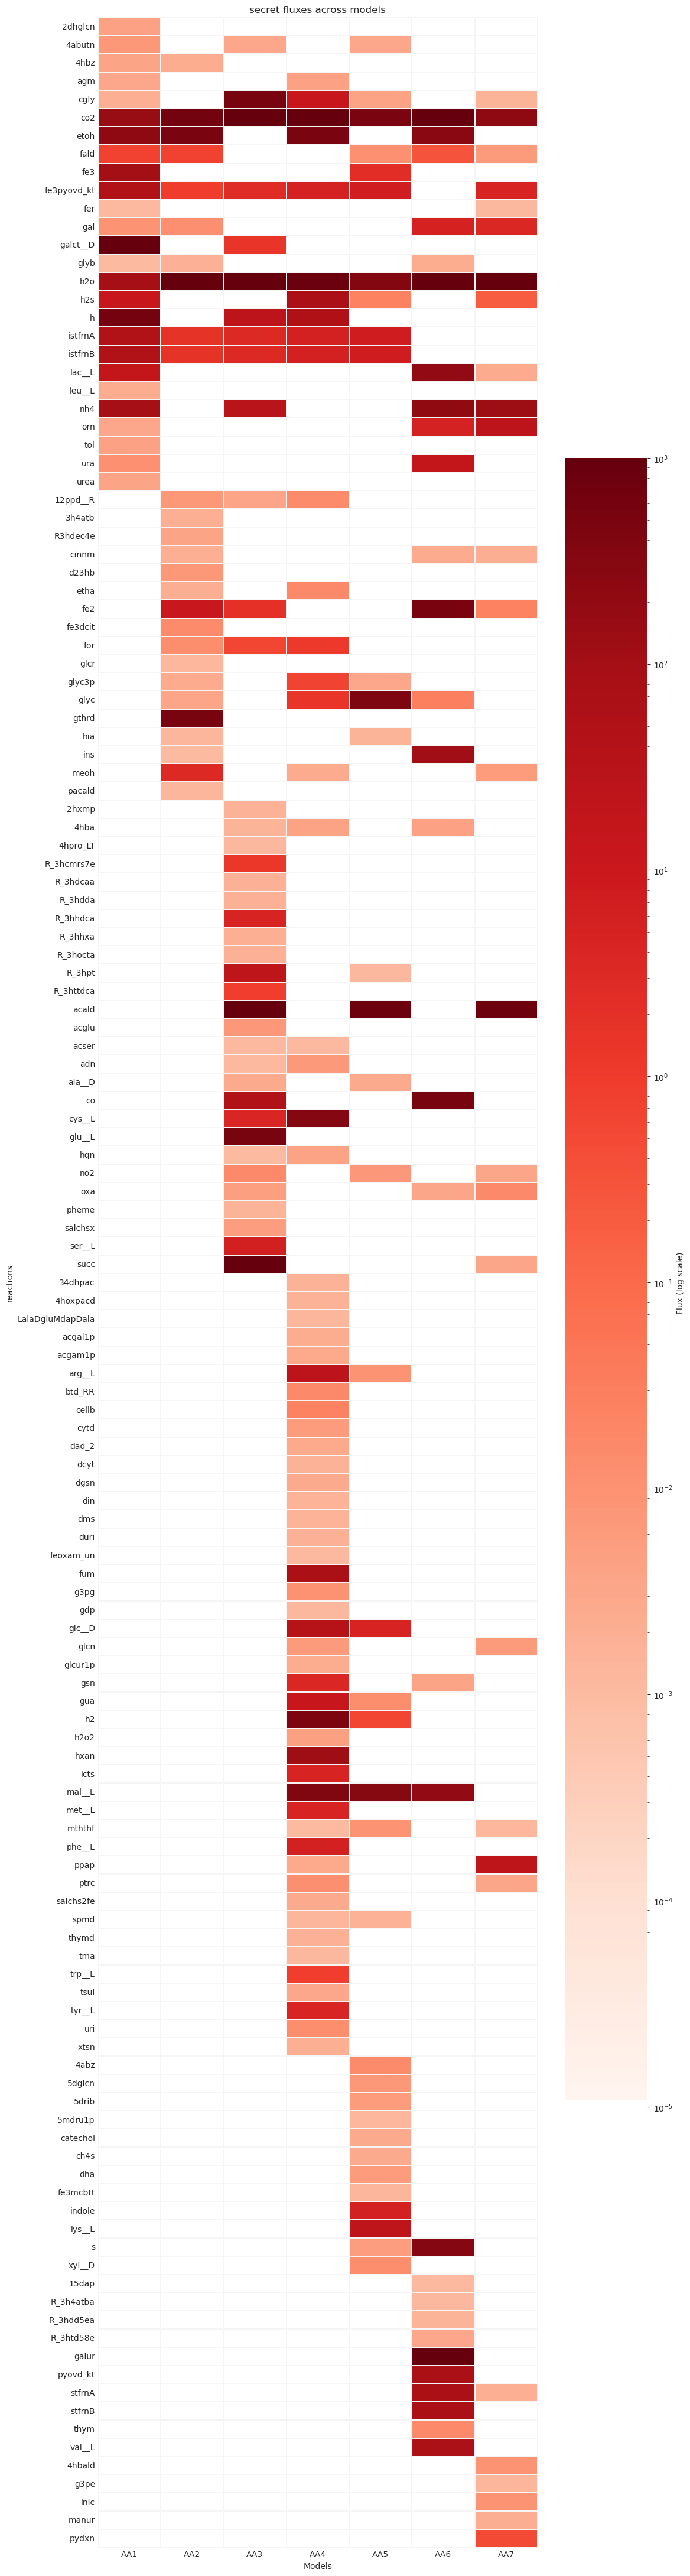

In [45]:
heatmap_fluxes_withinCommunity(plot_secretion, "secret")

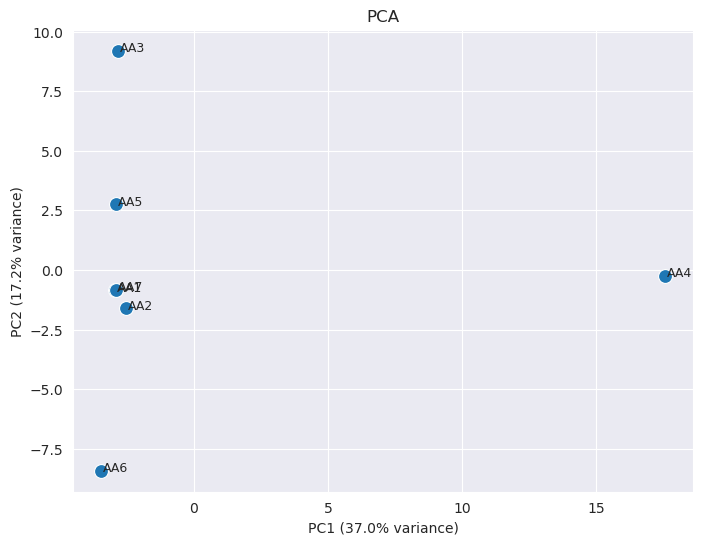

In [46]:
pca(plot_secretion.T)

In [ ]:
def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


vis_uptakes = []
for i in range(7):
    vis_uptakes.append(list(uptakes[i]["reaction"]))

vis_uptakes = [item for sublist in vis_uptakes for item in sublist]
len(vis_uptakes)
visualise_network(syncom, combined_med_wo_bz, list(vis_uptakes), "upsis.html")

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Run pFBA with context
with syncom:
    change_medium(syncom, combined_med_wo_bz)
    solution = pfba(syncom)
    fluxes = solution.fluxes

# Match uptake reactions ending in AA1–AA7 with negative flux
pattern = re.compile(r"^EX_.*_AA[1-7]$")

uptake_rxns = [rxn for rxn in syncom.reactions
               if pattern.match(rxn.id) and fluxes[rxn.id] < -1e-6]

print(f"Found {len(uptake_rxns)} uptake reactions matching criteria.")

def parse_rxn_id(rxn_id):
    core = rxn_id[3:]  # remove EX_
    parts = core.split('_')
    model_abbr = parts[-1]
    metabolite = '_'.join(parts[:-1])
    return metabolite, model_abbr

# Build flux records
records = []
for rxn in uptake_rxns:
    flux = -fluxes[rxn.id]
    metabolite, model = parse_rxn_id(rxn.id)
    records.append({"Metabolite": metabolite, "Model": model, "Flux": flux})

# Create DataFrame
df = pd.DataFrame(records)

# Optional: sort model labels AA1-AA7 numerically for consistent order
df["Model"] = pd.Categorical(df["Model"], categories=sorted(df["Model"].unique(), key=lambda x: int(x[-1])))

# Build Sankey with HoloViews
sankey = hv.Sankey(df, kdims=["Metabolite", "Model"], vdims="Flux")

sankey.opts(
    opts.Sankey(
        title="Uptake Fluxes (into individual models within Community)",
        width=1000,
        height=1500,          # a bit taller helps the eye
        edge_color="Model",
        node_padding=5,
        node_color="Model",
        cmap="Category10",   # one colour per model
        label_position='left',
        show_values=True,
        fontsize={'labels': 9, 'title': 13},
        tools=["hover"]
    )
)


# Spielplatz

In [ ]:
from pyvis.network import Network

def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


In [ ]:
vis_uptakes = []
for i in range(7):
    vis_uptakes.append(list(uptakes[i]["reaction"]))

vis_uptakes = [item for sublist in vis_uptakes for item in sublist]

In [ ]:
len(vis_uptakes)

In [ ]:
visualise_network(syncom, combined_med_wo_bz, list(vis_uptakes), "upsis.html")

### Phylo visualisation

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read("../phyliptree.phy", "newick")

fig = plt.figure(figsize=(12, 8))  # bigger figure helps
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, do_show=False, axes=ax)

plt.tight_layout()  # tries to optimize spacing
plt.show()


In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Read your tree (make sure it's in a supported format)
tree = Phylo.read("../phyliptree.phy", "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()


In [ ]:
from ete3 import Tree

# Load the tree from your .phy file
t = Tree("../phyliptree.phy", format=1)

# Show interactive tree viewer
t.show()


## Poster visualisations
Plots that were designed specifically for my poster for the MPA conference in Vienna; because they have to fit the poster maybe not all the infotmation is displayed that I normally would do or that I have done with my plots earlier in this notebook.

In [27]:
def filter_dataframe(df, threshold):
    # set values below the threshold to NaN
    filtered = df.where(df >= threshold)
    # drop rows where **all** values are NaN (i.e., all were below threshold)
    filtered = filtered.dropna(how='all')
    return filtered

In [28]:
threshold = 0.1

In [35]:
# get uptake fluxes only for our 7 models withput community
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="uptake", c7_all_ex="yes", dict_with_rxn="yes")


    flux_dict_sorted = {}
    # this is mostly if we would use community to change reaction names that community has the same as the individuals
    # attention (if relevant in the future): this overwrites flux values because EX_met1_e_AA1 is the same aus EX_met1_e_AA2
    for rxn_id, flux in flux_dict.items():
        # Rule 1: Remove '__AA[1-7]' suffix if present
        if re.search(r'__(AA[1-7])$', rxn_id):
            clean_id = re.sub(r'__(AA[1-7])$', '', rxn_id)
        # Rule 2: If ends with '_m', replace it with '_e'
        elif rxn_id.endswith('_m'):
            clean_id = rxn_id[:-2] + '_e'
        else:
            clean_id = rxn_id

        flux_dict_sorted[clean_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_uptakes_poster = filter_dataframe(df, threshold=threshold)

In [36]:
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="secret", c7_all_ex="yes", dict_with_rxn="yes")

    flux_dict_sorted = {}
    for rxn_id, flux in flux_dict.items():
        flux_dict_sorted[rxn_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_secrets_poster = filter_dataframe(df, threshold=threshold)

<Axes: >

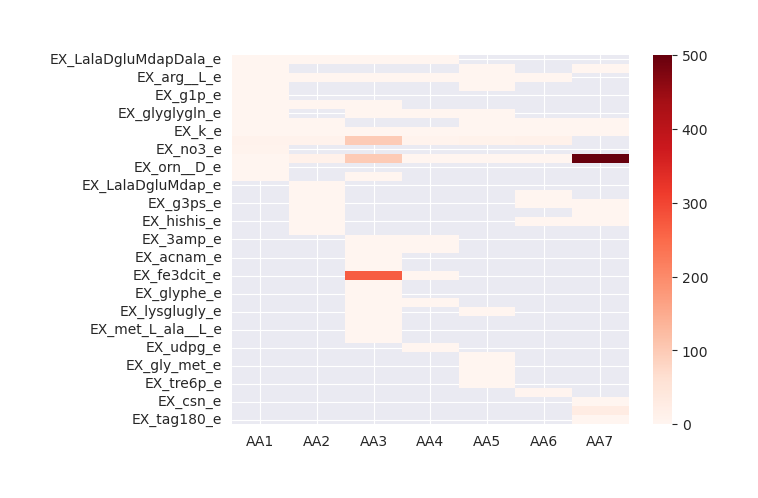

In [170]:
sns.heatmap(df_uptakes_poster, cmap="Reds")

### Upset Plot

In [26]:
# rename cols so they show up as the labels
name_changes = {"AA1": "Sma",
                   "AA2": "Bpi",
                   "AA3": "Cpu",
                   "AA4": "Elu",
                   "AA5": "Cin",
                   "AA6": "Hro",
                   "AA7": "Ppu"}

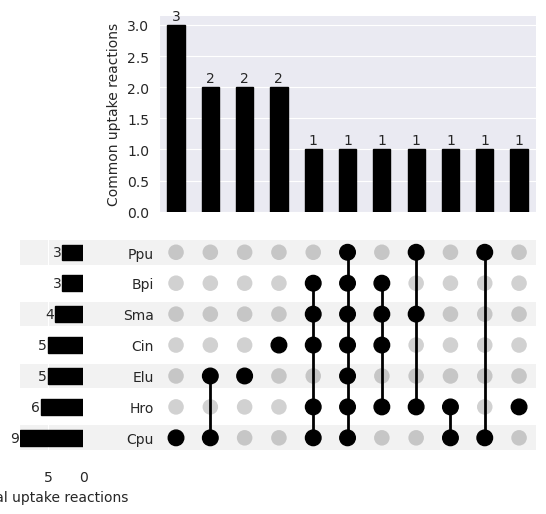

In [37]:
# Make boolean matrix: True = uptake present
bool_df = df_secrets_poster.notna()
bool_df = bool_df.rename(columns=name_changes)

# Convert to UpSet input format (multi-index of species presence)
upset_data = from_indicators(bool_df)

# Plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    sort_by='cardinality'  # Sort by size of overlap (descending)
).plot()

plt.gca().set_ylabel("Common uptake reactions")
upset["totals"].set_xlabel("Total uptake reactions")

#plt.savefig("../Figures/upset_niches.svg", format="svg", bbox_inches="tight")
plt.show()


In [293]:
from matplotlib.patches import Patch

def plot_fluxes(df_uptake, df_secretion, model_name, threshold=threshold):
    # Rename model_name for display
    display_name = name_changes.get(model_name, model_name)

    # Get the model object (e.g. AA1) to extract metabolite names
    model = models[model_name]

    # Get and filter fluxes
    uptake = df_uptake[model_name].dropna()
    uptake = uptake[uptake.abs() > threshold]

    secretion = df_secretion[model_name].dropna()
    secretion = secretion[secretion.abs() > threshold]
    secretion = -abs(secretion)

    # Create a combined DataFrame with flux values and labels
    combined = pd.concat([uptake, secretion])
    flux_type = ['uptake'] * len(uptake) + ['secretion'] * len(secretion)
    combined_df = pd.DataFrame({'flux': combined, 'type': flux_type})

    # Sort by absolute flux value
    combined_df['abs_flux'] = combined_df['flux'].abs()
    combined_df = combined_df.sort_values(by='abs_flux', ascending=False)

    # Get metabolite names
    def get_met_name(rid):
        rxn = model.reactions.get_by_id(rid)
        return list(rxn.metabolites.keys())[0].name

    x_labels = [get_met_name(rid) for rid in combined_df.index]

    # Set colors
    color_map = {'uptake': 'mediumseagreen', 'secretion': 'orange'}
    bar_colors = [color_map[t] for t in combined_df['type']]

    # Plot
    plt.figure(figsize=(10,6))
    plt.bar(range(len(combined_df)), combined_df['flux'], color=bar_colors)

    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel('log-scaled flux [mmol/(gDW h)]')
    plt.title(f'Uptake (positive) and Secretion (negative) fluxes for {display_name}')

    plt.xticks(ticks=range(len(combined_df)), labels=x_labels, rotation=45, ha='right')
    plt.yscale('symlog', linthresh=threshold)
    plt.ylim(combined_df['flux'].min() - 50, combined_df['flux'].max() + 10)

    # Add legend
    legend_elements = [
        Patch(facecolor='mediumseagreen', label='Uptake'),
        Patch(facecolor='orange', label='Secretion')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"../Figures/fluxes_{display_name}.svg", format="svg", bbox_inches="tight")
    plt.show()


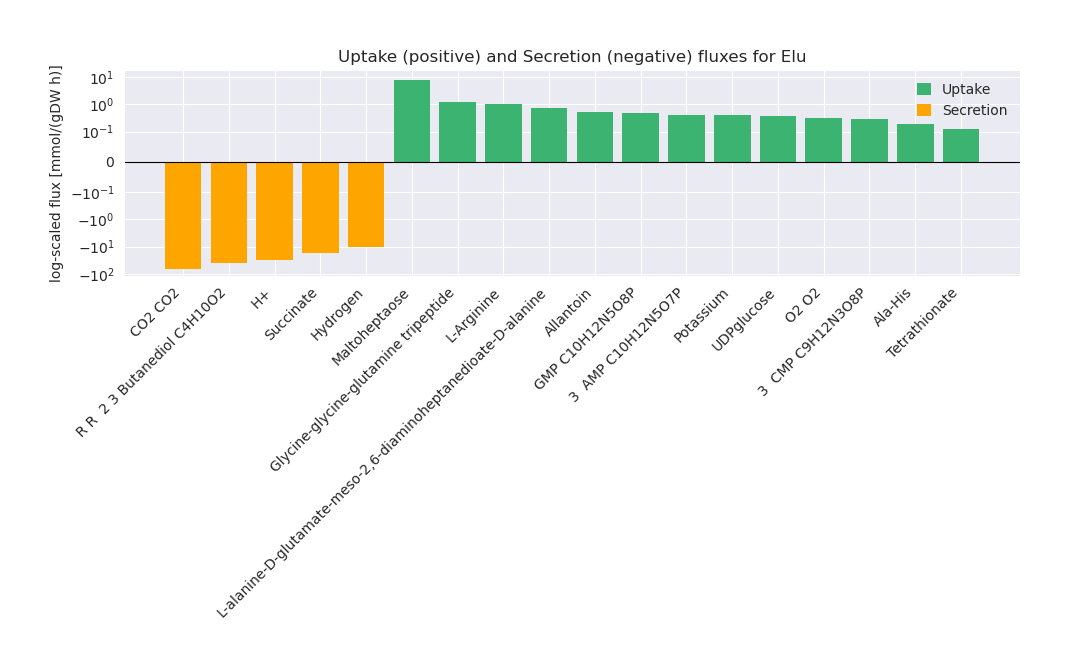

In [294]:
plot_fluxes(df_uptakes_poster, df_secrets_poster, "AA4")

# End

In [66]:
AA1f.metabolites.sheme_p

Metabolite identifier,sheme_p
Name,Siroheme C42H36FeN4O16
Memory address,0x74db72539900
Formula,C42H36FeN4O16
Compartment,C_p
In 0 reaction(s),
